# Sysarmy - Predicción de sueldos - 2019.1

## Objetivo

Generar modelos para establecer un sueldo dadas las otras respuestas a las preguntas de la encuesta de sysarmy.

## Metodología

Primero vamos a ver qué respuestas tenemos a cada pregunta independientemente. Esta primera exploración nos da una impresión de los datos disponibles, los posibles outliers (respuestas atípicas), qué datos están desbalanceados (tienen mucha asimetría en las respuestas, por ejemplo muy poca gente de Catamarca responde).

Después vamos a ver cuál es el sueldo promedio y la variabilidad de cada respuesta usando _boxplot_.

Luego generaremos modelos simplificados con una pequeña muestra para entender cómo funcionan. Los modelos a generar serán LinearRegression, KNN, Random Forest, xgboost y CatBoost.

La mayoría de las preguntas, sino todas, son de respuestas de tipo categóricas. Esto suele ser difícil de manejar para modelos de Machine Learning porque se necesita llevar todos los valores a un mismo espacio, es decir, poder establecer un grado de similitud entre un hombre en Jujuy y un hombre en Santa Fe o una mujer en Jujuy. Lo que vamos a hacer para pasar estas columnas a valores numéricos es el promedio de sueldos para ese valor en nuestra muestra de entrenamiento.

Aplicaremos cross validation con 5 folds y usaremos r2 como métrica.

Una vez entrenado el modelo, buscaremos outliers viendo las observaciones que más difieren de lo esperado y vemos si querremos excluirlas.

In [175]:
import pandas as pd

df = pd.read_csv('2019.1 - Encuesta de remuneración salarial - Argentina.csv', skiprows=3)
df

,Me identifico,Tengo,Dónde estás trabajando,Años de experiencia,Años en la empresa actual,Años en el puesto actual,¿Gente a cargo?,Nivel de estudios alcanzado,Estado,Carrera,...,Orientación sexual,¿Tenés algún tipo de discapacidad?,¿Sentís que esto te dificultó el conseguir trabajo?,¿A qué eventos de tecnología asististe en el último año?,Cantidad de empleados,Actividad principal,¿La recomendás como un buen lugar para trabajar?,¿Cómo calificás las políticas de diversidad e inclusión?,¿A cuántos kilómetros de tu casa queda la oficina?,Beneficios extra
0,Hombre,22,Catamarca,2.0,1.0,1.0,0,Universitario,En curso,ING informática,...,Heterosexual,NaN,NaN,NaN,1001-2000,Producto basado en Software,8,9,2.0,Capacitaciones y/o cursos
1,Hombre,23,Catamarca,2.0,1.0,1.0,0,Secundario,Completado,Ing informática,...,Heterosexual,NaN,NaN,Charlas online,51-100,Producto basado en Software,8,10,2.0,"Capacitaciones y/o cursos, Licencia de paterni..."
2,Mujer,35,Chaco,8.0,7.0,2.0,2,Posgrado,En curso,MTI,...,dgsdg,NaN,No,varios,201-500,Otras industrias,4,4,0.2,"Capacitaciones y/o cursos, Licencia de paterni..."
3,Hombre,41,Chaco,20.0,2.0,10.0,0,Universitario,Completado,Lic en sistemas,...,Heterosexual,NaN,NaN,Ninguno,1-10,Servicios / Consultoría de Software / Digital,5,1,-1.0,"Horarios flexibles, Vacaciones flexibles (adic..."
4,Hombre,35,Chaco,5.0,3.0,2.0,0,Universitario,Completado,Analisis en Sistemas,...,Heterosexual,NaN,No,NaN,501-1000,Producto basado en Software,8,8,1.0,"Capacitaciones y/o cursos, Clases de idiomas, ..."
5,Hombre,38,Chaco,16.0,16.0,16.0,0,Terciario,Incompleto,Analista de Sistemas,...,Heterosexual,NaN,No,Ninguno,201-500,Otras industrias,6,4,2.0,Ninguna de las anteriores
6,Hombre,30,Chaco,9.0,5.0,5.0,3,Terciario,Completado,T S P,...,Heterosexual,NaN,No,NaN,201-500,Otras industrias,6,10,2.0,"Abono de celular y/o Internet, Comidas pagas/s..."
7,Hombre,32,Chaco,10.0,2.0,2.0,0,Universitario,Incompleto,Ing. en Sistemas,...,Heterosexual,NaN,NaN,Ninguno :(,1001-2000,Otras industrias,5,5,5.0,Ninguna de las anteriores
8,Hombre,28,Chaco,7.0,3.0,1.0,2,Universitario,Incompleto,Ingeniería en Sistemas,...,Heterosexual,NaN,No,NaN,51-100,Servicios / Consultoría de Software / Digital,10,5,-1.0,"Horarios flexibles, Vacaciones flexibles (adic..."
9,Hombre,29,Chaco,0.0,0.0,0.0,0,Universitario,En curso,Ingenieria en Sistemas,...,Heterosexual,NaN,No,NaN,501-1000,Producto basado en Software,5,5,3.0,Capacitaciones y/o cursos


## Gráficos de respuestas

Vamos a ver las respuestas a cada una de las preguntas. Esto nos puede ayudar a tener una idea de qué tipo de respuestas se obtuvieron a grandes rasgos, como si la mayoría de la gente era hombre o vivía en la Ciudad Autónoma de Buenos Aires. También nos puede ayudar a detectar valores anómales, como gente de 200 años.

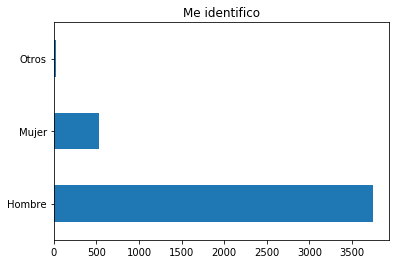

In [159]:
%matplotlib inline
df['Me identifico'].value_counts().plot.barh(title='Me identifico');

Ahora veamos la edad agrupando cada 5 años.

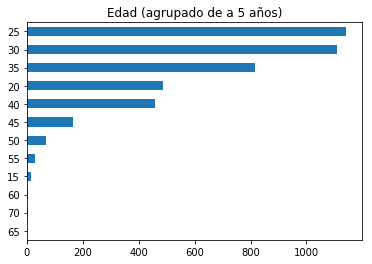

In [158]:
df['Tengo'].apply(lambda x: 5 * (x // 5)).value_counts(sort=True, ascending=True).plot.barh(title='Edad (agrupado de a 5 años)');

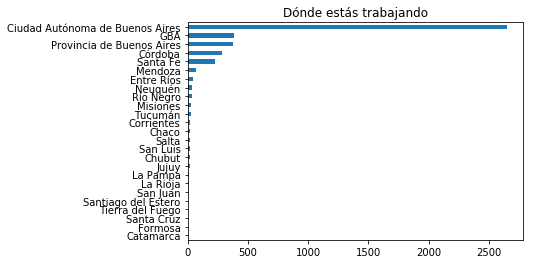

In [157]:
df['Dónde estás trabajando'].value_counts(sort=True, ascending=True).plot.barh(title='Dónde estás trabajando');

Veamos la cantidad de años de trabajo que tiene la gente agrupadas cada tres años para mejorar la visualización.

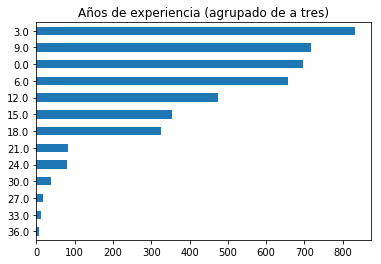

In [156]:
df['Años de experiencia'].apply(lambda x: 3 * (x // 3)).value_counts(sort=True, ascending=True).tail(20).plot.barh(title='Años de experiencia (agrupado de a tres)');

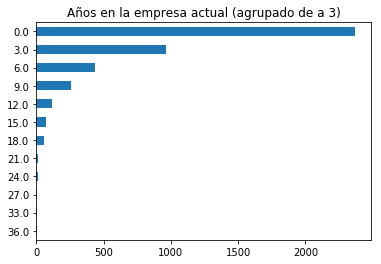

In [155]:
df['Años en la empresa actual'].apply(lambda x: 3 * (x // 3)).value_counts(sort=True, ascending=True).tail(20).plot.barh(title='Años en la empresa actual (agrupado de a 3)');

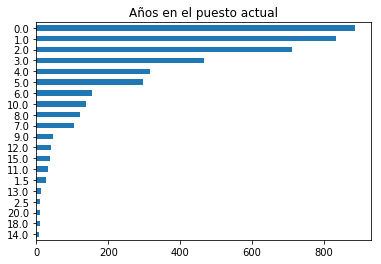

In [154]:
df['Años en el puesto actual'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='Años en el puesto actual');

La mayoría de la gente parece haber estado menos de 5 años en su trabajo actual.

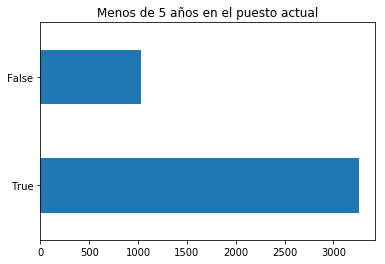

In [153]:
(df['Años en el puesto actual'] < 5).value_counts().plot.barh(title='Menos de 5 años en el puesto actual');

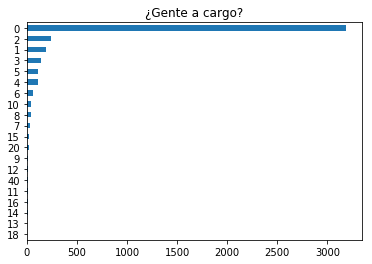

In [152]:
df['¿Gente a cargo?'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='¿Gente a cargo?');

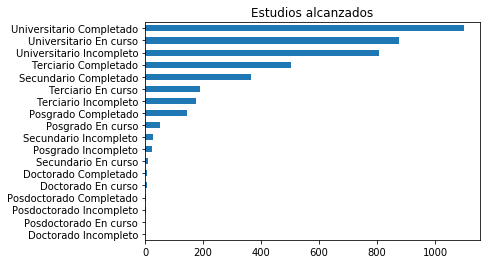

In [150]:
df.apply(lambda row: '{} {}'.format(row['Nivel de estudios alcanzado'], row['Estado']), axis=1).value_counts(sort=True, ascending=True).tail(20).plot.barh(title='Estudios alcanzados');

In [10]:
import re #ahre
regex_replace_map = {
    '^(Ing\.?|In?geni?[ea]r([íi]a|a|o))( en| de|) (.*)$': 'Ingeniería en \\4',
    '^(Ing\.?|Ingeni?er([íi]a|a|o|))$': 'Ingeniería',
    '^[LI]ic(enciatura|enciad[ao]|\.|)( en| de|) (.*)$': 'Licenciatura en \\3',
    '^Analistas?( de| en) (.*)$': 'Analista de \\2',
    '^(Tec\.? |T[eé]cnic(atura|a|o))(.*)$': 'Tecnicatura\\3',
    '^(Dr\.?|Doctor(ado|a|))( en| de|) (.*)$': 'Doctorado en \\4',
    '^Contador(a|).*$': 'Contador Público',
    '^Programador(a|).*$': 'Programación',
    '^(Abocac[íi]a|abogad[ao])$': 'Abogacía',
    '^(.*)ing[\. ](.+)$': '\\1Ingeniería \\2',
    '^(.*)lic[\. ](.+)$': '\\1Licenciatura \\2',
    '^(.*)(mg|mag|magister|maestr[íi]a)[\. ](.+)$': '\\1Maestría \\3',
    '^(.*)informaci[óo]n(.*)$': '\\1Información\\2',
    '^(.*)computaci[óo]n(.*)$': '\\1Computación\\2',
    '^(.*)inform[áàa]tica(.*)$': '\\1Informática\\2',
    '^(.*)programaci[óo]n(.*)$': '\\1Programación\\2',
    '^(.*)licenciatura(.*)$': '\\1Licenciatura\\2',
    '^(.*)electr[óo]nica(.*)$': '\\1Electrónica\\2',
    '^(.*)el[ée]ctrica(.*)$': '\\1Eléctrica\\2',
    '^(.*)tecnolog[íi]a(.*)$': '\\1Tecnología\\2',
    '^(.*)administraci[óo]n(.*)$': '\\1Administración\\2',
    '^(.*)sistem[as]s(.*)$': '\\1Sistemas\\2',
    '^(.*)ingeniero[as](.*)$': '\\1Ingeniería\\2',
    '^(.*)analista(.*)$': '\\1Analista\\2',
    '^(.*)(adm|admin)[ \.](.*)$': '\\1Administración \\2',
    '^(.*)inform[aá]ticos(.*)$': '\\1Informáticos\\2',
    '^(.*)liciencia(.*)$': '\\1licencia\\2', # OMG!
    '^(.*)ciencias?(.*)$': '\\1Ciencias\\2',
    '^(.*)cs\.?(.+)$': '\\1Ciencias\\2',
    '^(.*)an[áàa]lisis(.*)$': '\\1Análisis\\2',
    '^(.*)gesti[óo]n(.*)$': '\\1Gestión\\2',
    '^(.*)ux(.*)$': '\\1UX\\2',
    '^(.*)superior(.*)$': '\\1Superior\\2',
    '^(.*)rrhh(.*)$': '\\1Recursos Humanos\\2',
    '^(.*)empresa(.*)$': '\\1Empresa\\2',
    '^(.*)im[áa]gen(.*)$': '\\1Imágen\\2',
    '^(.*)sonido(.*)$': '\\1Sonido\\2',
    '^(.*)diseño(.*)$': '\\1Diseño\\2',
    '^(.*)electr[óo]nico(.*)$': '\\1Electrónico\\2',
    '^(.*)seguridad(.*)$': '\\1Seguridad\\2',
    '^(.*)higiene(.*)$': '\\1Higiene\\2',
    '^(.*)mec[áa]nica(.*)$': '\\1Mecánica\\2',
    '^(.*)telecomunicaciones(.*)$': '\\1Telecomunicaciones\\2',
    '^(.*)teleinform[áa]tica(.*)$': '\\1Teleinformática\\2',
    '^(.*)industrial(.*)$': '\\1Industrial\\2',
    '^(.*)universitari(.*)$': '\\1Universitari\\2',
    '^(.*)gr[áa]fico(.*)$': '\\1Gráfico\\2',
    '^(.*)desarrollo(.*)$': '\\1Desarrollo\\2',
    '^(.*)software(.*)$': '\\1Software\\2',
    '^(.*)social(.*)$': '\\1Social\\2',
    '^traductor(a|ado|)( P[úu]blico| de .+)?$': 'Traductorado Público',
    '^(.*)p[úu]blico(.*)$': '\\1Público\\2',
    '^(.*)trabajo(.*)$': '\\1Trabajo\\2',
    '^(.*)sitio(.*)$': '\\1Sitio\\2',
    '^(.*)filosof[íi]a(.*)$': '\\1Filosofía\\2',
    '^(.*)redes(.*)$': '\\1Redes\\2',
    '^(.*)psicolog[íi]a(.*)$': '\\1Psicología\\2',
    '^(.*)programador(.*)$': '\\1Programador\\2',
    '^(.*)biom[ée]dic(.*)$': '\\1Biomédic\\2',
    '^(.*)web(.*)$': '\\1Web\\2',
    '^(.*)arte(.*)$': '\\1Arte\\2',
    '^(.*)dela(.*)$': '\\1de la\\2',
    '^(.*)en en(.*)$': '\\1 en \\2',
    '^(.*) de (.*)$': '\\1 de \\2',
    '^(.*) en (.*)$': '\\1 en \\2',
    '^(.*)comunica(dor|dora|ci[óo]n)(.*)$': '\\1Comunicación\\3',
    '^(.*)telecomunicaci[óo]n(es)?(.*)$': '\\1Telecomunicaciones\\3',
    '^(.*)visual(.*)$': '\\1Visual\\2',
    '^fot[óo]graf(a|o|ia|ía)$': 'Fotografía',
    '^(.*)  (.*)$': '\\1 \\2',
    '^(TSP|T S P|T\.S\.P\.?)$': 'Tecnicatura Superior en Programación',
    '^(TSU|T S U|T\.S\.U\.?)(.*)$': 'Tecnicatura Superior Universitaria\\2',
    '^(ISI|I S I|I\.S\.I\.?)$': 'Ingeniería en Sistemas de Información',
    '^(.*)T\.? sup[\.](.*)$': '\\1Tecnicatura Superior\\2',
    '^(Tecnicatura|Ingeniería)( en | )(Industrial|Civil|Electrónic[ao]|Biom[ée]dica|Eléctrica|Mecánica)$': '\\1 \\3',
    '^(Tecnicatura|Ingeniería) Electrónic[ao]$': '\\1 Electrónica',
    '^(Ingeniería|Licenciatura) en Sistemas?(| de Información| en Información| de la Información| Inform[áa]ticos)$': '\\1 en Sistemas de Información',
    '^(.*)Superior Programación(.*)$': '\\1Superior en Programación\\2',
    '^(.*)Tecnicatura Universitario(.*)$': '\\1Tecnicatura Universitaria\\2',
    '^(.*)Tecnicaturaen(.*)$': '\\1Tecnicatura en\\2',
    '^(.*)TecnicaturaSuperior(.*)$': '\\1Tecnicatura Superior\\2',
    '^(.*)TecnicaturaProgramación(.*)$': '\\1Tecnicatura en Programación\\2',
    '^Tecnicatura Programador(.*)$': 'Tecnicatura en Programación',
    '^(LCC|Ciencias Computación|Licenciatura en Computación|Ciencias de la Computación)$': 'Licenciatura en Ciencias de la Computación',
    '^(An[áa]lisis de Sistemas?|Analista( de|) Sistemas?).*$': 'Analista de Sistemas',
    '^(Diseñ(o|ador|adora) Multimedial?|Multimedia)$': 'Diseño Multimedial',
    '^(.*)Universitario en Sistemas(.*)$': '\\1Universitario de Sistemas\\2',
    '^(.*)\.$': '\\1',
}
for regex, pattern in regex_replace_map.items():
    compiled_regex = re.compile(regex, re.I)
    df['Carrera'] = df['Carrera'].str.strip().str.replace(compiled_regex, pattern)

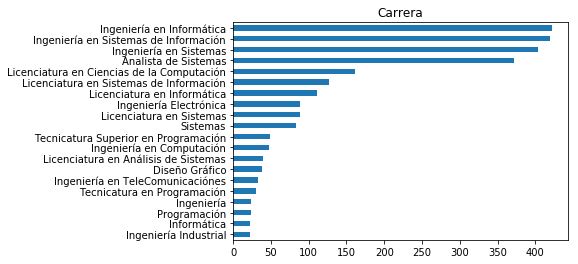

In [148]:
df['Carrera'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='Carrera');

In [12]:
regex_replace_map = {
    '(UTN|UTN .*|UTN ?F.*|Universidad Tec?nol[óo]gica Nacional( F.*)?)$': 'UTN',
    '(UBA|FIUBA|FCE-?UBA|Universidad de Buenos Aires|Buenos Aires)$': 'UBA',
    '(UNLP|Universidad Nacional de La Plata)$': 'UNLP',
    '(UNLaM|Universidad( Nacional|) de la Matanza|la matanza)$': 'UNLaM',
    '(UNS|Universidad Nacional del Sur)$': 'UNS',
    '(UNICEN|Universidad Nacional del Centro( de la (Provincia|Pcia\.?) de Buenos Aires)?)$': 'UNICEN',
    '(UNC|Universidad Nacional de C[óo]rdoba)$': 'UNC',
    '(UNRC|Universidad Nacional de R[ií]o Cuarto)$': 'UNRC',
    '(UNQ|Universidad Nacional de Quilmes|Unqui)$': 'UNQ',
    '(UADE|Universidad Argentina de la Empresa)$': 'UADE',
    '(UB|Universidad de Belgrano)$': 'UB',
    '(UK|(Universidad )?Kennedy)$': 'UK',
    '(UCES|Universidad de Ciencias Empresariales y Sociales)$': 'UCES',
    '(UM|Universidad de Mor[óo]n|Mor[óo]n)$': 'UM',
    '(UP|Universidad de Palermo|Palermo)$': 'UP',
    '(CAECE|UCAECE|Universidad CAECE)$': 'CAECE',
    '(ORT|ORT Argentina)$': 'ORT',
    '(UAI|(Universidad )?Abierta Interamericana)$': 'UAI',
    '(UBP|(Universidad )?Blas Pascal)$': 'UBP',
    '(Universidad )?(Maim[óo]nides)$': 'Maimónides',
    '(UNLA|.*Lan[úu]s)$': 'UNLA',
    '(UNL|(Universidad )?Nacional del Litoral)$': 'UNL',
    '(UNLu|Universidad Nacional de Luj[áa]n)$': 'UNLu',
    '((Escuela .?)?(Multimedial? )?)?Da ?Vinci$': 'DaVinci',
    '(Universidad )?(Siglo 21|Siglo XXI)$': 'Siglo 21',
    '(UA|(Universidad )?Austral)$': 'UNL',
    '(UA|(Universidad )?Austral)$': 'UNL',
    '(Istea)$': 'ISTEA',
    '(UAP|Universidad Adventista del Plata)': 'UAP',
    '(UNJu|Universidad Nacional de Jujuy)': 'UNJu',
    '(UNCUYO|Universidad Nacional de Cuyo)': 'UNCUYO',
    '(ISSD|Instituto Superior Santo Domingo)': 'ISSD',
    '(UNSAM|Universidad Nacional de San Mart[ií]n)': 'UNSAM',
    '(UNLAR|Universidad Nacional de La Rioja)': 'UNLaR',
    '(UNCOMA|Universidad Nacional del Comahue)': 'UNCOMA',
    '(UDA|Universidad del Aconcagua)': 'UDA',
    '(IUA|Instituto Universitario Aeronautico)': 'IUA',
    '(-)$': 'DELETEME',
}
for regex, pattern in regex_replace_map.items():
    compiled_regex = re.compile(regex, re.I)
    df['Universidad'] = df['Universidad'].str.strip().str.replace(compiled_regex, pattern)

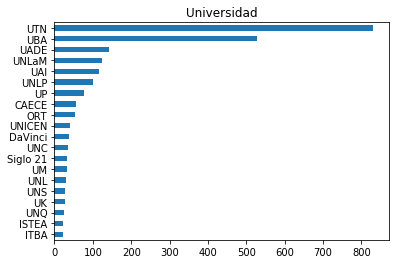

In [147]:
df['Universidad'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='Universidad');

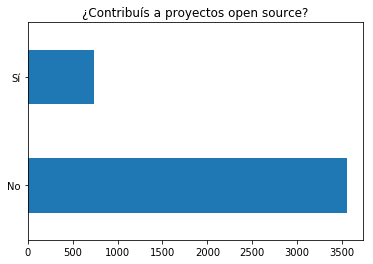

In [146]:
df['¿Contribuís a proyectos open source?'].value_counts().plot.barh(title='¿Contribuís a proyectos open source?');

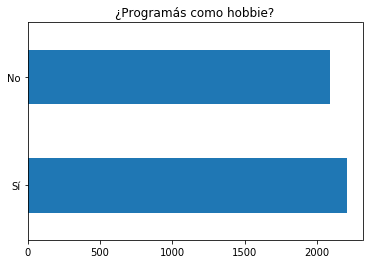

In [161]:
df['¿Programás como hobbie?'].value_counts().plot.barh(title='¿Programás como hobbie?');

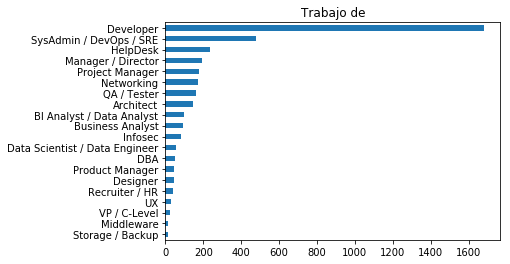

In [162]:
df['Trabajo de'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='Trabajo de');

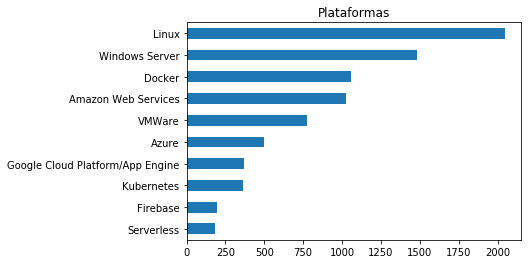

In [163]:
tech_count = {}
for x in df['Plataformas'].dropna():
    for key in x.split(','):
        key = key.strip()
        tech_count[key] = tech_count.get(key, 0) + 1
pd.Series(tech_count).sort_values(ascending=True).tail(10).plot.barh(title='Plataformas');

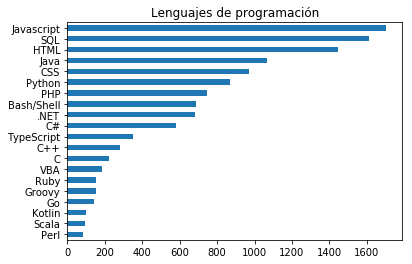

In [165]:
languages_count = {}
for x in df['Lenguajes de programación'].dropna():
    for key in x.split(','):
        key = key.strip()
        languages_count[key] = languages_count.get(key, 0) + 1
pd.Series(languages_count).sort_values(ascending=True).tail(20).plot.barh(title='Lenguajes de programación');

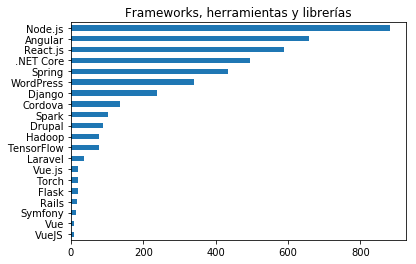

In [167]:
fw_count = {}
for x in df['Frameworks, herramientas y librerías'].dropna():
    for key in x.split(','):
        key = key.strip()
        fw_count[key] = fw_count.get(key, 0) + 1
pd.Series(fw_count).sort_values(ascending=True).tail(20).plot.barh(title='Frameworks, herramientas y librerías');

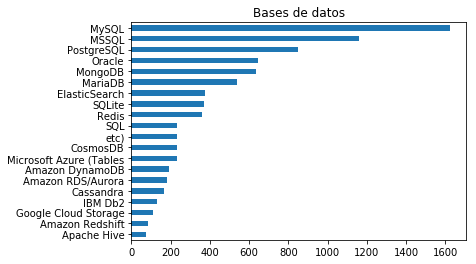

In [168]:
db_count = {}
for x in df['Bases de datos'].dropna():
    for key in x.split(','):
        key = key.strip()
        db_count[key] = db_count.get(key, 0) + 1
pd.Series(db_count).sort_values(ascending=True).tail(20).plot.barh(title='Bases de datos');

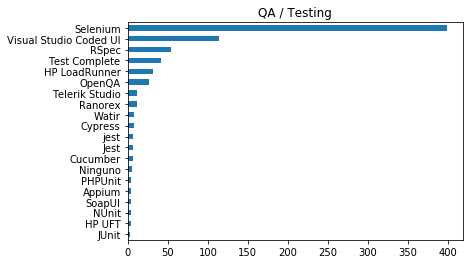

In [169]:
qat_count = {}
for x in df['QA / Testing'].dropna():
    for key in x.split(','):
        key = key.strip()
        qat_count[key] = qat_count.get(key, 0) + 1
pd.Series(qat_count).sort_values(ascending=True).tail(20).plot.barh(title='QA / Testing');

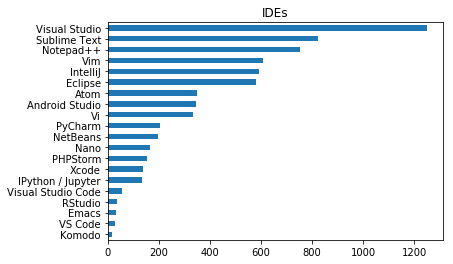

In [170]:
ide_count = {}
for x in df['IDEs'].dropna():
    for key in x.split(','):
        key = key.strip()
        ide_count[key] = ide_count.get(key, 0) + 1
pd.Series(ide_count).sort_values(ascending=True).tail(20).plot.barh(title='IDEs');

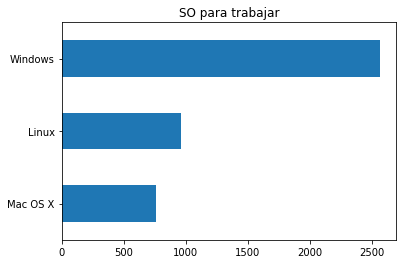

In [171]:
df['¿Qué SO usás en tu laptop/PC para trabajar?'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='SO para trabajar');

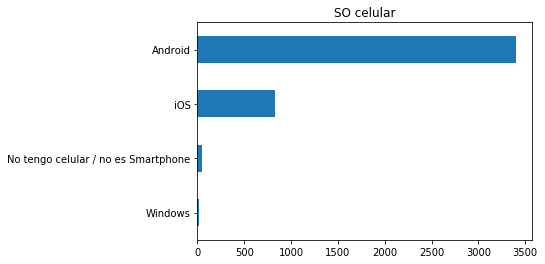

In [172]:
df['¿Y en tu celular?'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='SO celular');

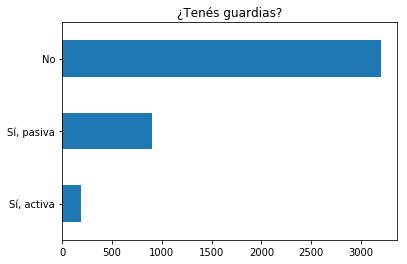

In [173]:
df['¿Tenés guardias?'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='¿Tenés guardias?');

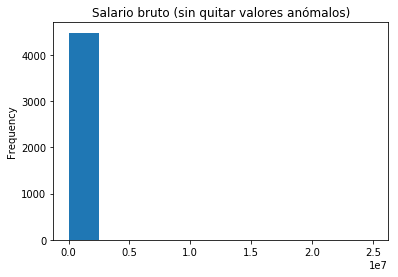

In [176]:
df['Salario mensual BRUTO (en tu moneda local)'].plot.hist(title='Salario bruto (sin quitar valores anómalos)');

In [177]:
df['Salario mensual BRUTO (en tu moneda local)'].sort_values().head()

1906    1.0
2124    1.0
43      1.0
2235    1.0
3916    1.0
Name: Salario mensual BRUTO (en tu moneda local), dtype: float64

In [28]:
df['Salario mensual BRUTO (en tu moneda local)'].sort_values().tail()

3274      931415.92
4029     1500000.00
2349     3572000.00
3169     5138262.00
3919    25000000.00
Name: Salario mensual BRUTO (en tu moneda local), dtype: float64

In [178]:
(df['Salario mensual BRUTO (en tu moneda local)'] < 10000).sum()

151

In [179]:
df[(df['Salario mensual BRUTO (en tu moneda local)'] < 12000) & (df['Salario mensual BRUTO (en tu moneda local)'] > 10000)]

,Me identifico,Tengo,Dónde estás trabajando,Años de experiencia,Años en la empresa actual,Años en el puesto actual,¿Gente a cargo?,Nivel de estudios alcanzado,Estado,Carrera,...,Orientación sexual,¿Tenés algún tipo de discapacidad?,¿Sentís que esto te dificultó el conseguir trabajo?,¿A qué eventos de tecnología asististe en el último año?,Cantidad de empleados,Actividad principal,¿La recomendás como un buen lugar para trabajar?,¿Cómo calificás las políticas de diversidad e inclusión?,¿A cuántos kilómetros de tu casa queda la oficina?,Beneficios extra
662,Mujer,20,Ciudad Autónoma de Buenos Aires,0.0,0.0,0.0,0,Universitario,En curso,Ingeniería en sistemas de información,...,Heterosexual,NaN,NaN,NaN,201-500,Servicios / Consultoría de Software / Digital,7,9,5.0,"Capacitaciones y/o cursos, Descuentos varios (..."
1075,Mujer,25,Ciudad Autónoma de Buenos Aires,0.0,0.0,0.0,0,Universitario,En curso,Ingeniería en sistemas,...,Heterosexual,NaN,NaN,Digital Summit 2018,1001-2000,Servicios / Consultoría de Software / Digital,8,9,9.0,"Capacitaciones y/o cursos, Descuentos varios (..."
1261,Mujer,21,Ciudad Autónoma de Buenos Aires,1.0,1.0,1.0,0,Universitario,En curso,Diseño gráfico,...,Bisexual o queer,NaN,NaN,NaN,1-10,Producto basado en Software,8,1,8.0,"Horarios flexibles, Vacaciones flexibles (adic..."
1976,Hombre,26,Ciudad Autónoma de Buenos Aires,0.0,0.0,0.0,0,Terciario,Completado,Diseño Multimedial,...,Pansexual,NaN,No,NaN,1-10,Servicios / Consultoría de Software / Digital,5,5,5.0,Comidas pagas/subvencionadas
2393,Hombre,71,Ciudad Autónoma de Buenos Aires,20.0,3.0,20.0,0,Universitario,Incompleto,ingenieria,...,Heterosexual,NaN,No,0,11-50,Otras industrias,2,2,5.0,Ninguna de las anteriores
2798,Hombre,22,Córdoba,1.0,1.0,1.0,0,Universitario,En curso,Ingeniería en Software,...,Heterosexual,NaN,NaN,PyData Córdoba,201-500,Otras industrias,6,7,9.6,"Capacitaciones y/o cursos, Descuentos varios (..."
2804,Hombre,20,Córdoba,1.0,1.0,1.0,0,Universitario,En curso,Ing. en Sistemas de Informacion,...,Heterosexual,NaN,NaN,Facebook Developers Circle CBA,11-50,Otras industrias,7,8,8.0,"Capacitaciones y/o cursos, Playroom"
2949,Hombre,38,Córdoba,5.0,5.0,5.0,0,Universitario,En curso,Ingenieria en Telecomunicaciones,...,Heterosexual,NaN,NaN,NaN,51-100,Otras industrias,8,9,4.0,"Capacitaciones y/o cursos, Horarios flexibles"
3124,Hombre,32,Entre Ríos,5.0,4.0,4.0,2,Universitario,En curso,Licenciatura en Sistemas,...,Heterosexual,NaN,No,Conferencias de Seguridad Informática,1-10,Producto basado en Software,6,6,12.0,Ninguna de las anteriores
3890,Hombre,28,Provincia de Buenos Aires,1.0,1.0,1.0,0,Universitario,Completado,Técnico superior en programación,...,Heterosexual,NaN,NaN,NaN,1-10,Producto basado en Software,10,10,3.0,"Horarios flexibles, Vacaciones flexibles (adic..."


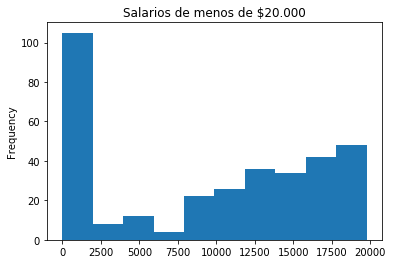

In [182]:
df[(df['Salario mensual BRUTO (en tu moneda local)'] < 20000)]['Salario mensual BRUTO (en tu moneda local)'].plot.hist(title='Salarios de menos de $20.000');

In [32]:
df['Salario mensual BRUTO (en tu moneda local)'].sort_values().tail(20)

59        330000.00
58        332200.00
409       340000.00
3694      356783.00
299       370000.00
500       370000.00
3192      370000.00
591       440000.00
2109      450000.00
3489      550000.00
4129      576000.00
746       600000.00
1274      600000.00
2387      630000.00
2489      720000.00
3274      931415.92
4029     1500000.00
2349     3572000.00
3169     5138262.00
3919    25000000.00
Name: Salario mensual BRUTO (en tu moneda local), dtype: float64

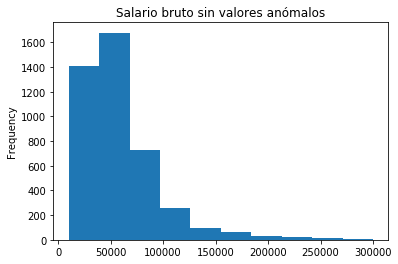

In [183]:
df[(df['Salario mensual BRUTO (en tu moneda local)'] >= 10000) & (df['Salario mensual BRUTO (en tu moneda local)'] <= 300000)]['Salario mensual BRUTO (en tu moneda local)'].plot.hist(title='Salario bruto sin valores anómalos');

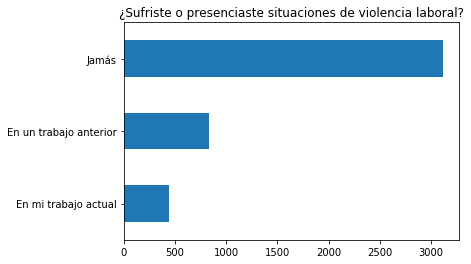

In [185]:
df['¿Sufriste o presenciaste situaciones de violencia laboral?'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='¿Sufriste o presenciaste situaciones de violencia laboral?');

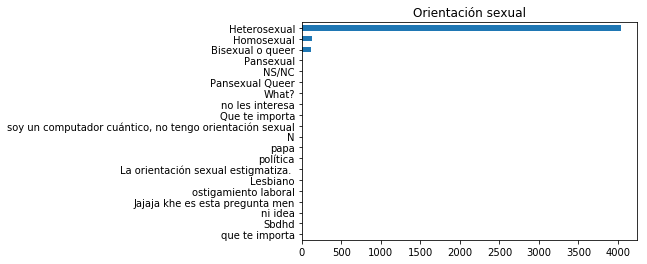

In [186]:
df['Orientación sexual'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='Orientación sexual');

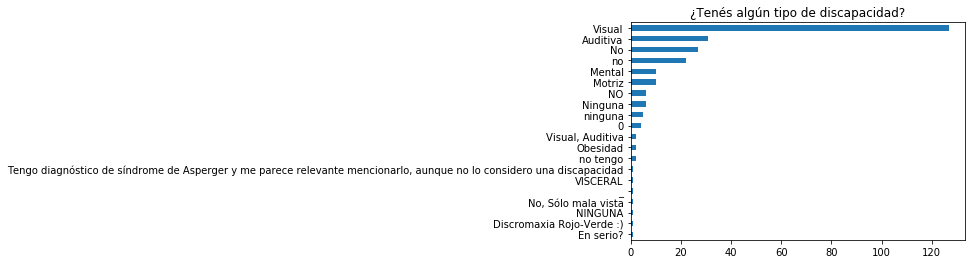

In [187]:
df['¿Tenés algún tipo de discapacidad?'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='¿Tenés algún tipo de discapacidad?');

'reduced in 0.586207'

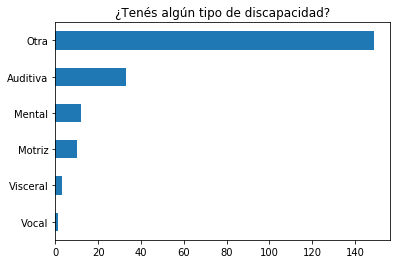

In [188]:
def normalize_dataframe_column(df_in, column_name, regex_assign_map):
  """
  Given a Dataframe (df), a column name that identifies the column to sanitize,
  applies an in-place replacement for each pair regex-value in the map
  """
  df_out = df_in.copy()
  for regex, value in regex_assign_map.items():
    compiled_regex = re.compile(regex, re.I)
    mask = df_in[ column_name ].str.strip().str.match(compiled_regex, na=False)
    df_out.loc[ mask, column_name ] = value
  
  # debug
  total, final = len(df_in[column_name].unique()), len(df_out[column_name].unique())
  display('reduced in {:02f}'.format((total - final) / total))
  return df_out

def normalize_dataframe_column_replace(df_in, column_name, regex_replace_map):
  """
  Given a Dataframe (df), a column name that identifies the column to sanitize,
  applies an in-place replacement for each pair regex-value in the map
  """
  df_out = df_in.copy()
  for regex, pattern in regex_replace_map.items():
    compiled_regex = re.compile(regex, re.I)
    df_out[ column_name ] = df_out[ column_name ].str.strip().str.replace(compiled_regex, pattern)
  
  # debug
  total, final = len(df_in[column_name].unique()), len(df_out[column_name].unique())
  display('reduced in {:02f}'.format((total - final) / total))
  return df_out

df = normalize_dataframe_column(df, '¿Tenés algún tipo de discapacidad?', {
    '^(_|-|no( tengo)?|ningun[oa]|nada|0|)$': None,
    '.*auditiv[oa].*': 'Auditiva',
    '.*visual.*': 'Visual',
    'mental': 'Mental',
    'motriz': 'Motriz',
    'vis?c?eral': 'Visceral',
    '^no, solo mala vista$': None,
    '^no tengo ninguna discapacidad$': None,
    '^tolerancia$': None,
    '^no tengo discapacidad$': None,
    r'^en serio\?$': None,
    r'^idealismo\?$': None,
    r'^si soy lagarto$': None,
    r'^windows$': None,
    r'^social$': None,
    r'^no les interesa$': None,
    r'^edad$': None,
    r'^ninguna \¿Habia que llenar esta respuesta\?$': None,
})
df['¿Tenés algún tipo de discapacidad?'] = df['¿Tenés algún tipo de discapacidad?'].apply(lambda val: val if val in (None, 'Auditiva', 'Mental', 'Motriz', 'Vocal', 'Visceral') or not isinstance(val, str) else 'Otra')
df['¿Tenés algún tipo de discapacidad?'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='¿Tenés algún tipo de discapacidad?');

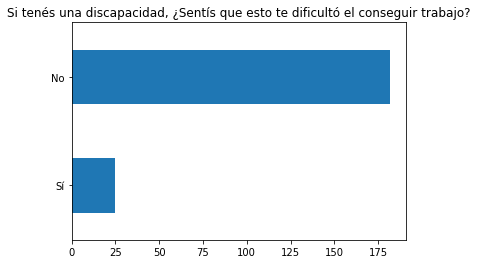

In [189]:
df[~df['¿Tenés algún tipo de discapacidad?'].isna()]['¿Sentís que esto te dificultó el conseguir trabajo?'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='Si tenés una discapacidad, ¿Sentís que esto te dificultó el conseguir trabajo?');

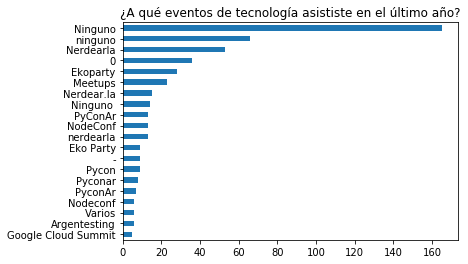

In [190]:
df['¿A qué eventos de tecnología asististe en el último año?'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='¿A qué eventos de tecnología asististe en el último año?');

'reduced in 0.000000'

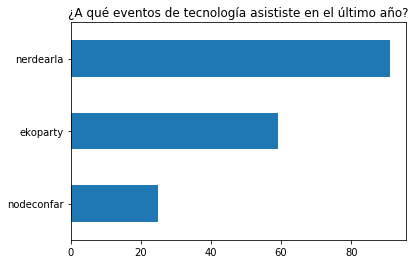

In [192]:
df = normalize_dataframe_column(df, '¿A qué eventos de tecnología asististe en el último año?', {
    '^nerdear\.?la$': 'nerdearla',
    '^eko ?partys?$': 'ekoparty',
    '^pycon(?:ar)?$': 'pyconar',
    '^nodeconf(?:ar)?$': 'nodeconfar',
})

df['¿A qué eventos de tecnología asististe en el último año?'] = df['¿A qué eventos de tecnología asististe en el último año?'].apply(lambda val: val if val in (None, 'nerdearla', 'ekoparty', 'nodeconfar',) or not isinstance(val, str) else None)
df['¿A qué eventos de tecnología asististe en el último año?'].value_counts(sort=True, ascending=True).tail(20).plot.barh(title='¿A qué eventos de tecnología asististe en el último año?');

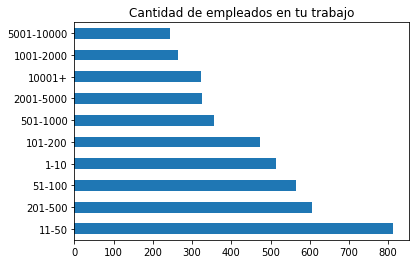

In [193]:
df['Cantidad de empleados'].value_counts().plot.barh(title='Cantidad de empleados en tu trabajo');

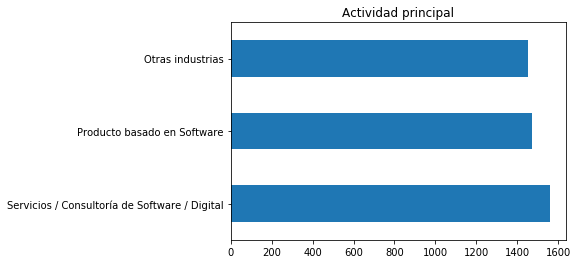

In [194]:
df['Actividad principal'].value_counts().plot.barh(title='Actividad principal');

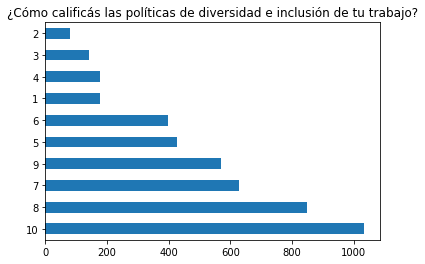

In [195]:
df['¿Cómo calificás las políticas de diversidad e inclusión?'].value_counts().plot.barh(title='¿Cómo calificás las políticas de diversidad e inclusión de tu trabajo?');

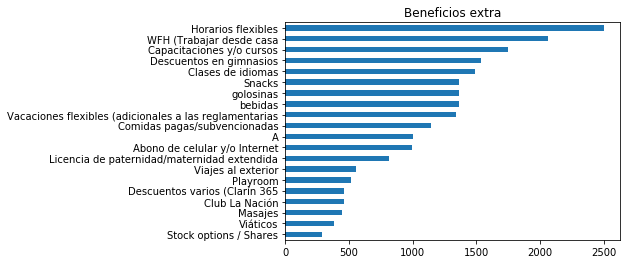

In [196]:
all_benefits = ','.join(df['Beneficios extra'].tolist())
benefits = set(x for x in [item.strip('.,-)()').strip() for s in df['Beneficios extra'].tolist() for item in s.split(',')] if x not in ('', 'a', 'no', 'nada', 'Ninguna', 'etc', 'Ninguna de las anteriores'))
pd.Series({b: all_benefits.count(b) for b in benefits}).sort_values(ascending=True).tail(20).plot.barh(title='Beneficios extra');

In [197]:
df = df[df['Años de experiencia'] < 40]
df = df[df['Tengo'] < 80]
df = df[df['Años en la empresa actual'] < 40]
df = df[(df['Salario mensual BRUTO (en tu moneda local)'] >= 10000) & (df['Salario mensual BRUTO (en tu moneda local)'] <= 300000)]

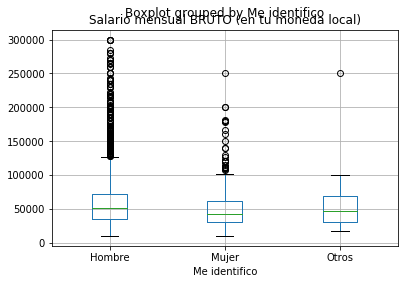

In [216]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', 'Me identifico');

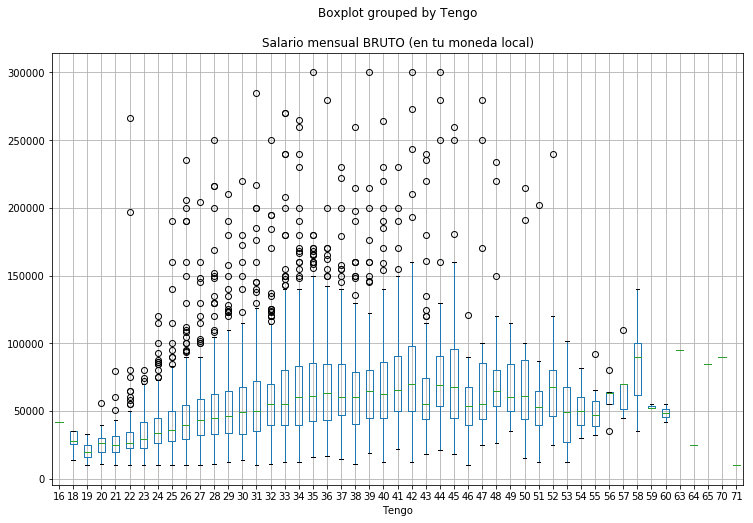

In [47]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', 'Tengo', figsize=(12, 8));

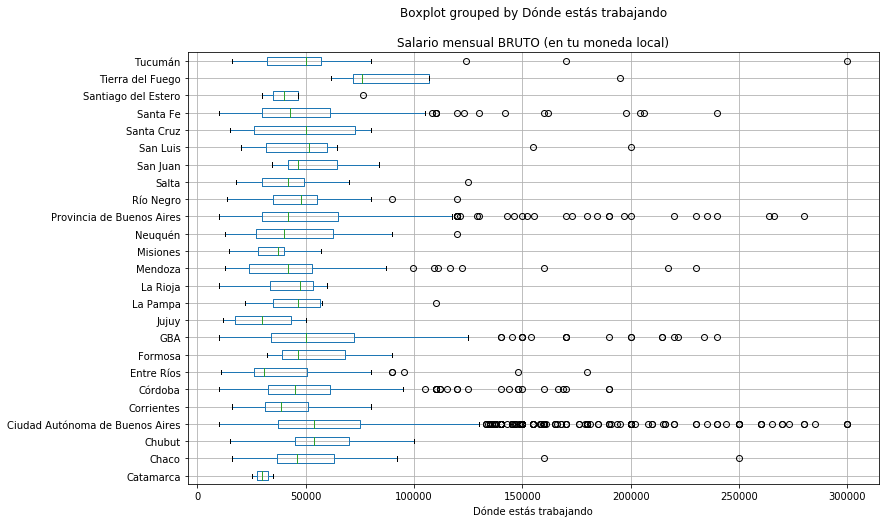

In [48]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', 'Dónde estás trabajando', figsize=(12, 8), vert=False);

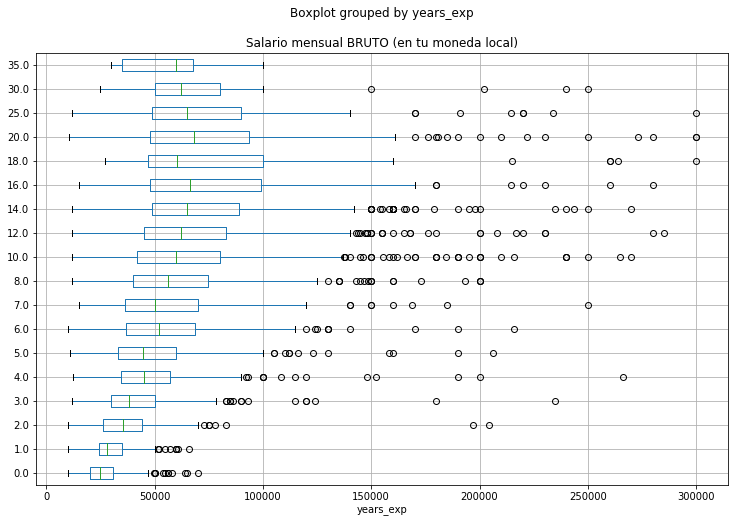

In [49]:
def years_exp(y):
    if y < 8: return int(y)
    if y < 20: return 2 * (y // 2) # 6->6, 7->6, 8->8, 9->8
    return (y // 5) * 5
    
df['years_exp'] = df['Años de experiencia'].apply(years_exp)# .value_counts(sort=True, ascending=True).tail(20).plot.barh();
df.boxplot('Salario mensual BRUTO (en tu moneda local)', 'years_exp', figsize=(12, 8), vert=False);

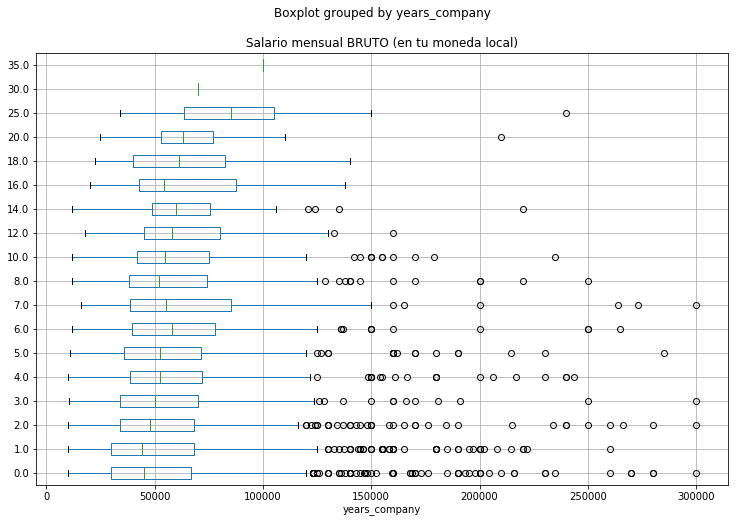

In [50]:
df['years_company'] = df['Años en la empresa actual'].apply(years_exp)
df.boxplot('Salario mensual BRUTO (en tu moneda local)', 'years_company', figsize=(12, 8), vert=False);

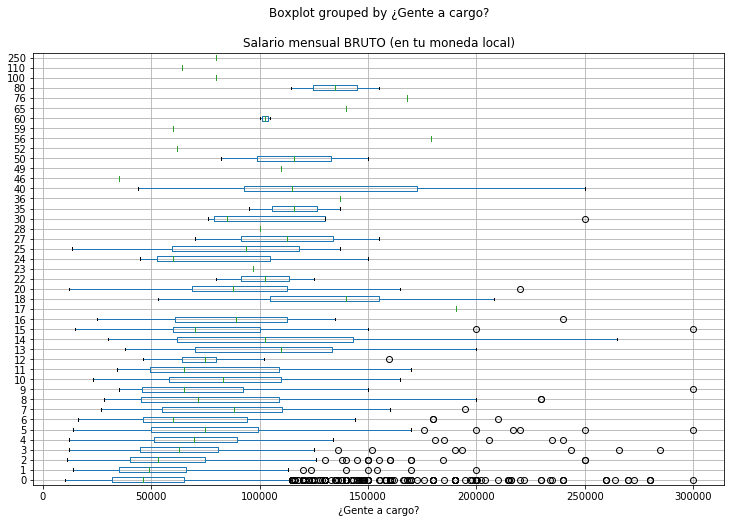

In [51]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', '¿Gente a cargo?', figsize=(12, 8), vert=False);

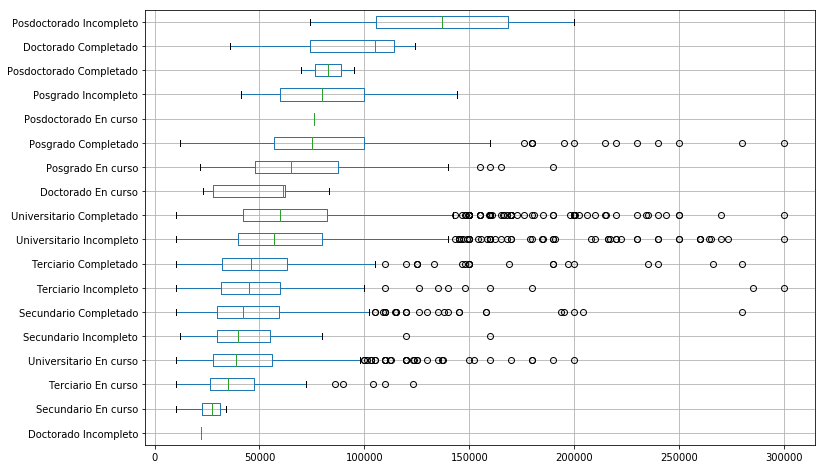

In [218]:
def boxplot_sorted(df, by, column):
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    meds = df2.median().sort_values()
    df2[meds.index].boxplot(figsize=(12, 8), vert=False)

df['studied'] = df.apply(lambda row: '{} {}'.format(row['Nivel de estudios alcanzado'], row['Estado']), axis=1)

boxplot_sorted(df, by=["studied"], column="Salario mensual BRUTO (en tu moneda local)")

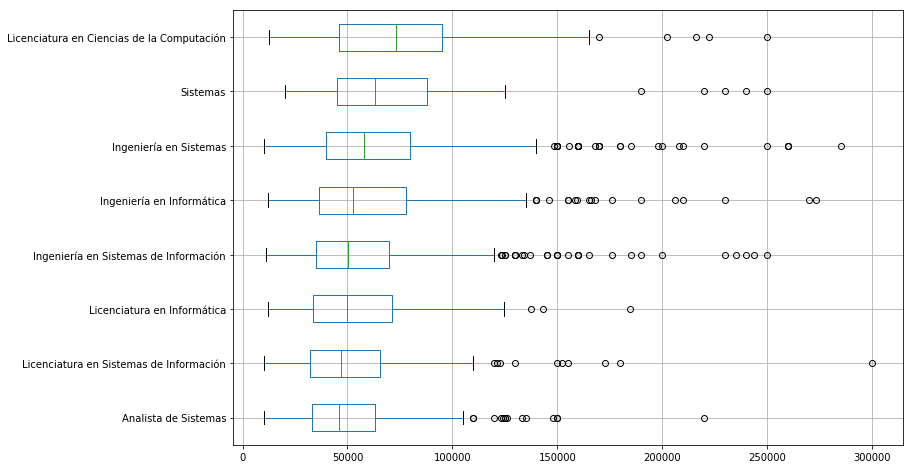

In [53]:
df['Carrera'].value_counts(sort=True, ascending=True).tail(20)#.plot.barh();
valid_carrera = 'Sistemas','Licenciatura en Informática','Licenciatura en Sistemas de Información','Licenciatura en Ciencias de la Computación','Ingeniería en Sistemas','Analista de Sistemas','Ingeniería en Informática','Ingeniería en Sistemas de Información'
boxplot_sorted(df[df['Carrera'].apply(lambda c: c in valid_carrera)], by=["Carrera"], column="Salario mensual BRUTO (en tu moneda local)")

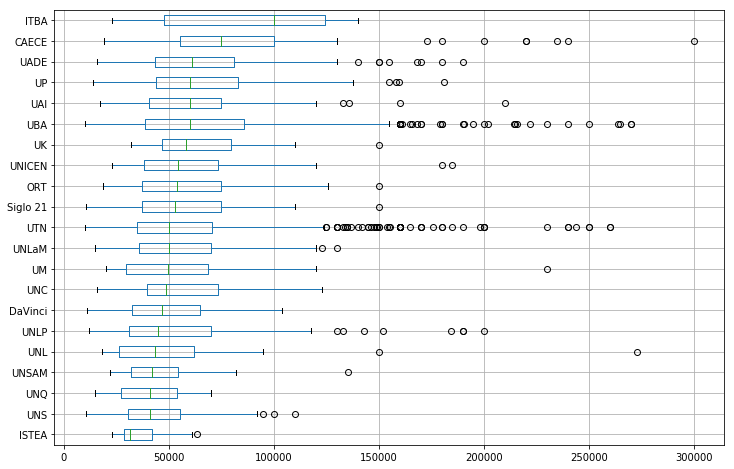

In [54]:
vc = df['Universidad'].value_counts()
univs = vc[vc > 20].index.tolist()
boxplot_sorted(df[df['Universidad'].apply(lambda c: c in univs)], by=["Universidad"], column="Salario mensual BRUTO (en tu moneda local)")

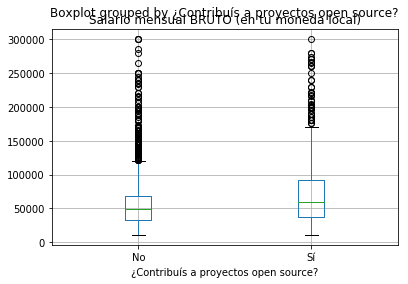

In [55]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', '¿Contribuís a proyectos open source?');

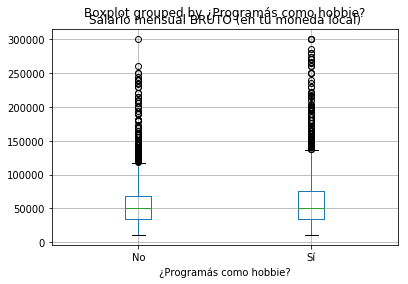

In [56]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', '¿Programás como hobbie?');

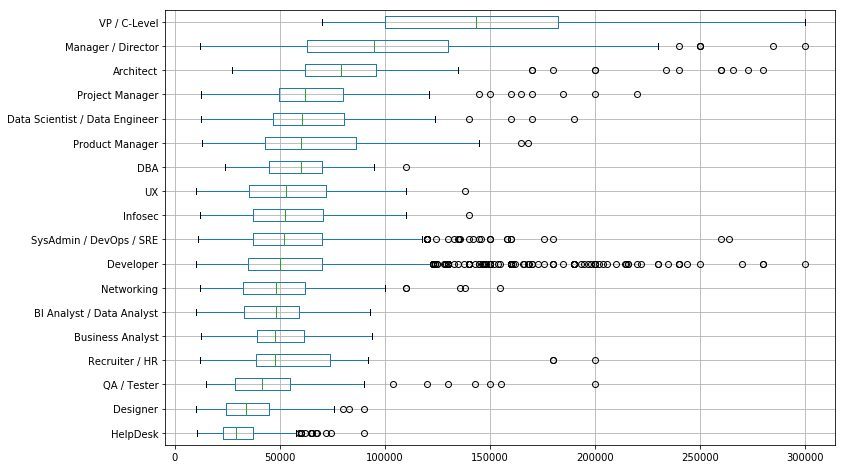

In [57]:
vc = df['Trabajo de'].value_counts()
univs = vc[vc > 20].index.tolist()
boxplot_sorted(df[df['Trabajo de'].apply(lambda c: c in univs)], by=["Trabajo de"], column="Salario mensual BRUTO (en tu moneda local)")

In [58]:
tech_counts = pd.Series(tech_count).sort_values(ascending=True)
tech_counts = tech_counts[tech_counts > 20]
tech_counts

SAP                                   28
HP-UX                                 73
*BSD                                  95
Mainframe                             97
IBM Cloud / Watson                   108
Solaris                              116
AIX                                  129
Heroku                               131
OpenStack                            136
Serverless                           193
Firebase                             213
Kubernetes                           375
Google Cloud Platform/App Engine     398
Azure                                510
VMWare                               806
Amazon Web Services                 1068
Docker                              1100
Windows Server                      1557
Linux                               2147
dtype: int64

Varias preguntas daban la posibilidad de seleccionar más de una respuesta, en ese caso vamos a abrir cada uno de estso checkboxes a una columna propia. Por ejemplo hay gente que en su trabajo usa Linux, Windows y Docker, esas personas tendrán una columna para cada una de estas plataformas.

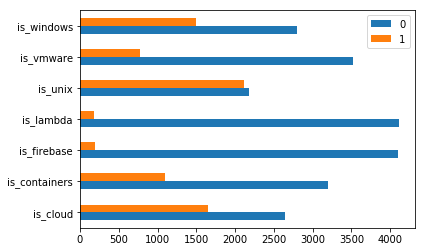

In [219]:
d = {}
for key, tech in {
        'unix': ('Linux', '*BSD', 'AIX', 'OpenStack', 'Solaris', 'HP-UX'),
        'windows': ('Windows', 'Windows Server'),
        'vmware': ('VMWare',),
        'containers': ('Docker', 'Kubernetes'),
        'cloud': ('Azure', 'Amazon Web Services', 'Google Cloud Platform/App Engine', 'OpenStack', 'Heroku', 'IBM Cloud / Watson',),
        'firebase': ('Firebase',),
        'lambda': ('Serverless',),
    }.items():
    d['is_{}'.format(key)] = df['Plataformas'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
    df['is_{}'.format(key)] = df['Plataformas'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
pd.DataFrame({x: v.value_counts() for x, v in d.items()}).T.plot.barh();

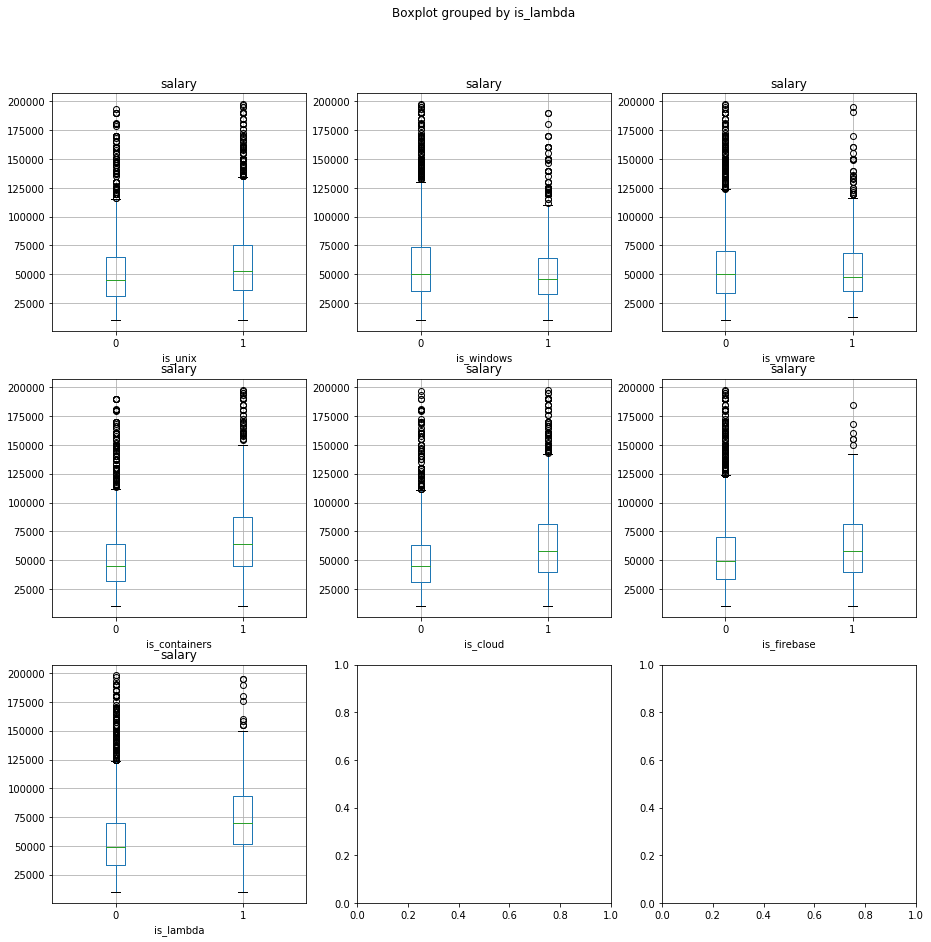

In [60]:
import matplotlib.pyplot as plt
_, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, _, _)) = plt.subplots(3, 3, figsize=(15, 15))
df['salary'] = df['Salario mensual BRUTO (en tu moneda local)']
df_low = df[df['Salario mensual BRUTO (en tu moneda local)'] < 200000]
df_low.boxplot('salary', 'is_unix', ax=ax1);
df_low.boxplot('salary', 'is_windows', ax=ax2);
df_low.boxplot('salary', 'is_vmware', ax=ax3);
df_low.boxplot('salary', 'is_containers', ax=ax4);
df_low.boxplot('salary', 'is_cloud', ax=ax5);
df_low.boxplot('salary', 'is_firebase', ax=ax6);
df_low.boxplot('salary', 'is_lambda', ax=ax7);

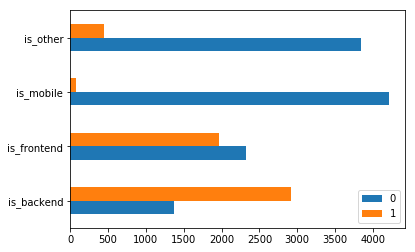

In [61]:
d = {}
for key, tech in {
        'frontend': ('Javascript', 'HTML', 'CSS', 'jQuery'),
        'backend': ('Java', 'PHP', 'Python', '.NET', 'NodeJS', 'C#', 'Ruby', 'Perl', 'Go', 'Scala'),
        'other': ('VB*', 'C++', 'C,', 'ABAP'),
        'mobile': ('Swift', 'Objective-C')
    }.items():
    d['is_{}'.format(key)] = df['Lenguajes de programación'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
    df['is_{}'.format(key)] = df['Lenguajes de programación'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
pd.DataFrame({x: v.value_counts() for x, v in d.items()}).T.plot.barh();

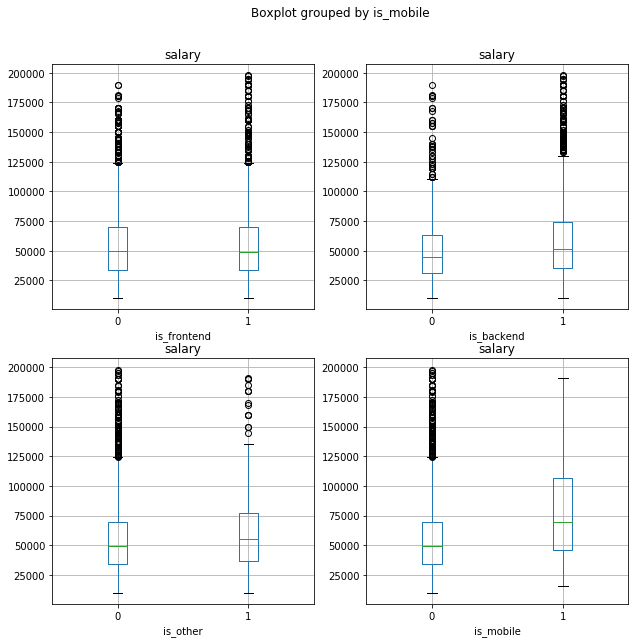

In [62]:
import matplotlib.pyplot as plt
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
df_low = df[df['Salario mensual BRUTO (en tu moneda local)'] < 200000]
df_low.boxplot('salary', 'is_frontend', ax=ax1);
df_low.boxplot('salary', 'is_backend', ax=ax2);
df_low.boxplot('salary', 'is_other', ax=ax3);
df_low.boxplot('salary', 'is_mobile', ax=ax4);

In [63]:
fw_counts = pd.Series(fw_count).sort_values(ascending=True)
fw_counts = fw_counts[fw_counts > 20]
fw_counts

Rails          22
Vue.js         23
Torch          24
Laravel        39
TensorFlow     81
Hadoop         85
Drupal         99
Spark         109
Cordova       142
Django        251
WordPress     365
Spring        447
.NET Core     520
React.js      620
Angular       689
Node.js       925
dtype: int64

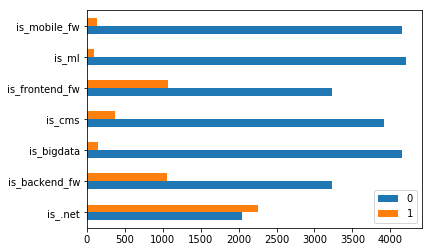

In [64]:
d = {}
for key, tech in {
        'frontend_fw': ('Angular', 'React.js', 'Vue.js'),
        'backend_fw': ('Node.js', 'Django', 'Laravel'),
        'mobile_fw': ('Cordova',),
        '.net': ('.NET Core'),
        'cms': ('WordPress', 'Drupal'),
        'bigdata': ('Spark', 'Hadoop'),
        'ml': ('TensorFlow', 'Torch',),
    }.items():
    d['is_{}'.format(key)] = df['Frameworks, herramientas y librerías'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
    df['is_{}'.format(key)] = df['Frameworks, herramientas y librerías'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
pd.DataFrame({x: v.value_counts() for x, v in d.items()}).T.plot.barh();

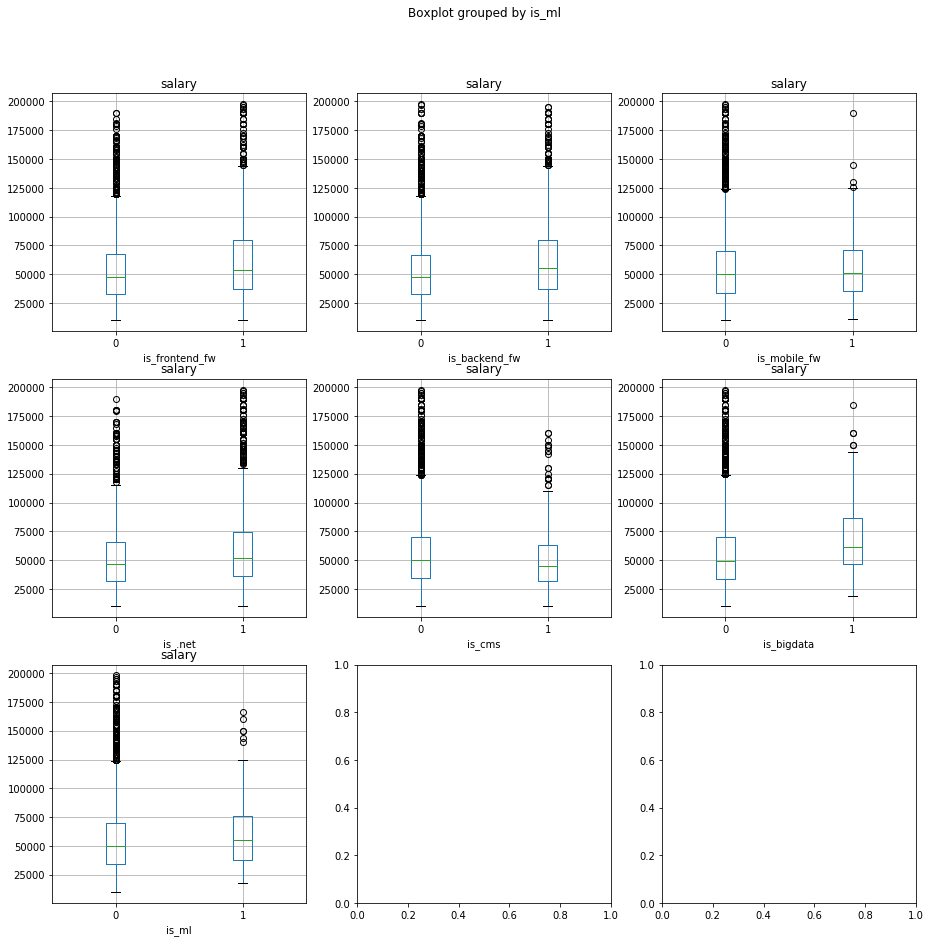

In [65]:
import matplotlib.pyplot as plt
_, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, _, _)) = plt.subplots(3, 3, figsize=(15, 15))
df_low = df[df['Salario mensual BRUTO (en tu moneda local)'] < 200000]
df_low.boxplot('salary', 'is_frontend_fw', ax=ax1);
df_low.boxplot('salary', 'is_backend_fw', ax=ax2);
df_low.boxplot('salary', 'is_mobile_fw', ax=ax3);
df_low.boxplot('salary', 'is_.net', ax=ax4);
df_low.boxplot('salary', 'is_cms', ax=ax5);
df_low.boxplot('salary', 'is_bigdata', ax=ax6);
df_low.boxplot('salary', 'is_ml', ax=ax7);

In [66]:
db_counts = pd.Series(db_count).sort_values(ascending=True)
db_counts = db_counts[db_counts > 20]
db_counts

Teradata                     22
Percona Server               22
ProxySQL                     23
Neo4j                        34
Apache HBase                 58
Informix                     62
Apache Hive                  80
Amazon Redshift              92
Google Cloud Storage        121
IBM Db2                     133
Cassandra                   172
Amazon RDS/Aurora           191
Amazon DynamoDB             204
CosmosDB                    239
etc)                        239
Microsoft Azure (Tables     239
SQL                         239
Redis                       376
SQLite                      389
ElasticSearch               389
MariaDB                     571
MongoDB                     661
Oracle                      671
PostgreSQL                  886
MSSQL                      1191
MySQL                      1703
dtype: int64

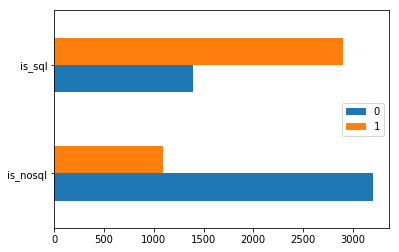

In [67]:
d = {}
for key, tech in {
        'sql': ('MySQL', 'MSSQL', 'PostgreSQL', 'Oracle', 'MariaDB', 'Microsoft Azure', 'IBM Db2'),
        'nosql': ('MongoDB', 'ElasticSearch', 'Redis', 'Amazon DynamoDB', 'Cassandra', 'Google Cloud Storage'),
    }.items():
    d['is_{}'.format(key)] = df['Bases de datos'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
    df['is_{}'.format(key)] = df['Bases de datos'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
pd.DataFrame({x: v.value_counts() for x, v in d.items()}).T.plot.barh();

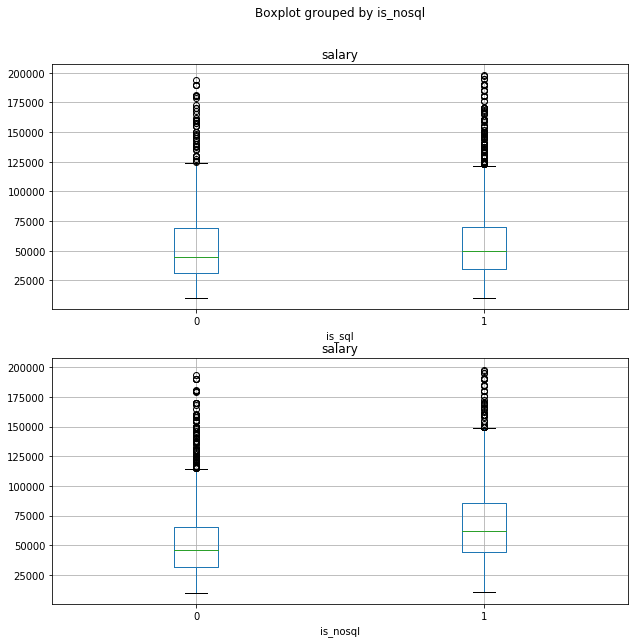

In [68]:
import matplotlib.pyplot as plt
_, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(10, 10))
df_low = df[df['Salario mensual BRUTO (en tu moneda local)'] < 200000]
df_low.boxplot('salary', 'is_sql', ax=ax1);
df_low.boxplot('salary', 'is_nosql', ax=ax2);

In [69]:
qat_counts = pd.Series(qat_count).sort_values(ascending=True)
qat_counts = qat_counts[qat_counts > 20]
qat_counts

HP LoadRunner              35
OpenQA                     36
Test Complete              49
RSpec                      58
Visual Studio Coded UI    128
Selenium                  418
dtype: int64

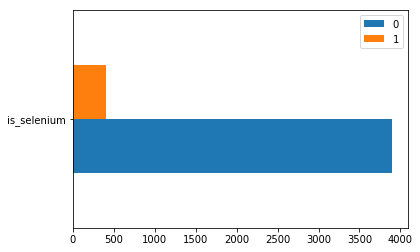

In [70]:
d = {}
for key, tech in {
        'selenium': ('Selenium',),
    }.items():
    d['is_{}'.format(key)] = df['QA / Testing'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
    df['is_{}'.format(key)] = df['QA / Testing'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
pd.DataFrame({x: v.value_counts() for x, v in d.items()}).T.plot.barh();

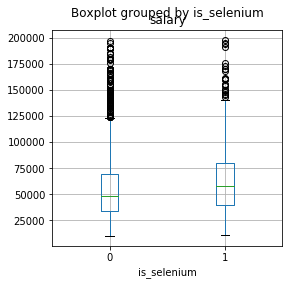

In [71]:
import matplotlib.pyplot as plt
_, ((ax1)) = plt.subplots(1, 1, figsize=(4, 4))
df_low = df[df['Salario mensual BRUTO (en tu moneda local)'] < 200000]
df_low.boxplot('salary', 'is_selenium', ax=ax1);

In [72]:
ide_counts = pd.Series(ide_count).sort_values(ascending=True)
ide_counts = ide_counts[ide_counts > 200]
ide_counts

NetBeans           209
PyCharm            212
Vi                 347
Atom               373
Android Studio     381
Eclipse            606
IntelliJ           618
Vim                625
Notepad++          783
Sublime Text       861
Visual Studio     1308
dtype: int64

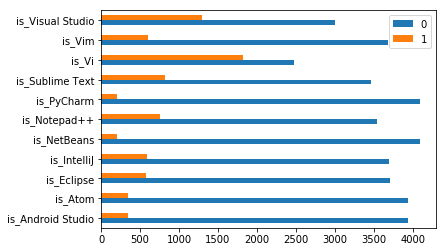

In [73]:
d = {}
for ide in ide_counts.index.tolist():
    key, tech = ide, (ide,)
    d['is_{}'.format(key)] = df['IDEs'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
    df['is_{}'.format(key)] = df['IDEs'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
pd.DataFrame({x: v.value_counts() for x, v in d.items()}).T.plot.barh();

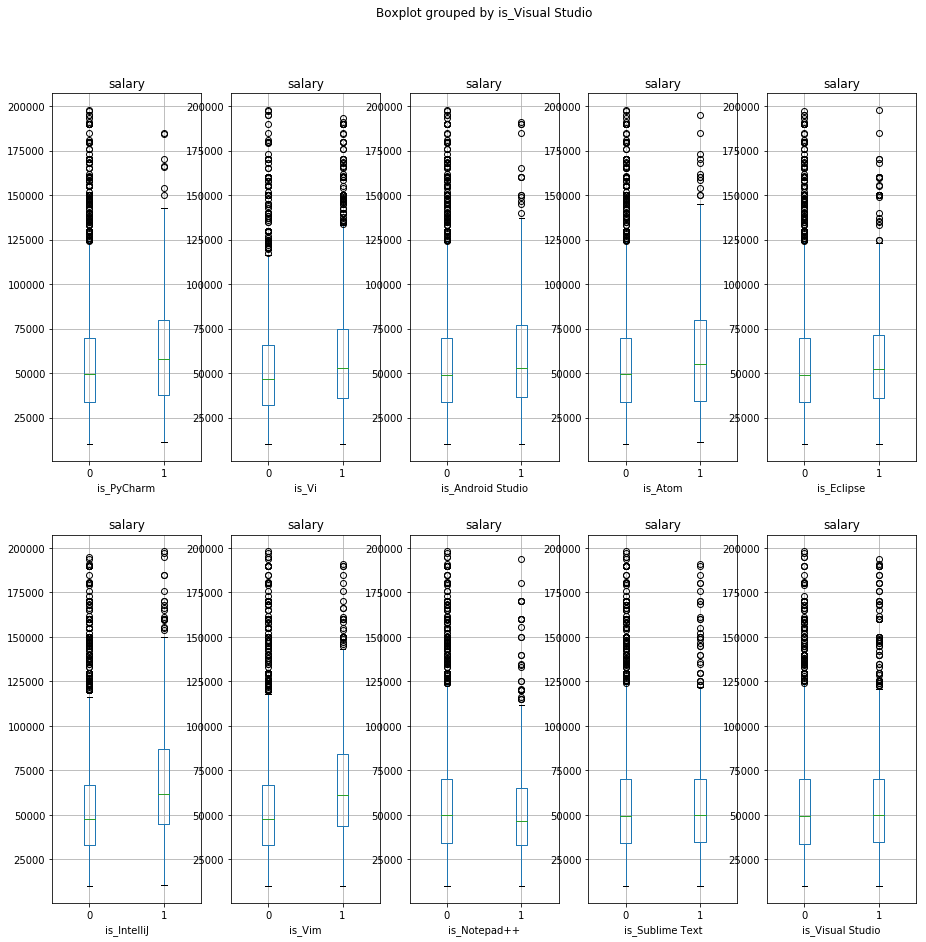

In [74]:
import matplotlib.pyplot as plt
_, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(15, 15))
df_low = df[df['Salario mensual BRUTO (en tu moneda local)'] < 200000]

df_low.boxplot('salary', 'is_PyCharm', ax=ax1);
df_low.boxplot('salary', 'is_Vi', ax=ax2);
df_low.boxplot('salary', 'is_Android Studio', ax=ax3);
df_low.boxplot('salary', 'is_Atom', ax=ax4);
df_low.boxplot('salary', 'is_Eclipse', ax=ax5);
df_low.boxplot('salary', 'is_IntelliJ', ax=ax6);
df_low.boxplot('salary', 'is_Vim', ax=ax7);
df_low.boxplot('salary', 'is_Notepad++', ax=ax8);
df_low.boxplot('salary', 'is_Sublime Text', ax=ax9);
df_low.boxplot('salary', 'is_Visual Studio', ax=ax10);

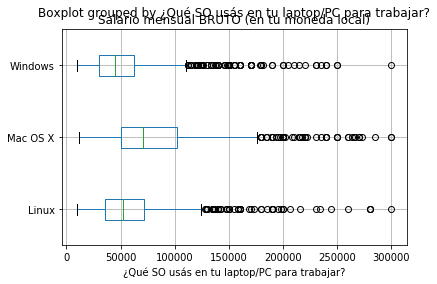

In [75]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', '¿Qué SO usás en tu laptop/PC para trabajar?', vert=False);

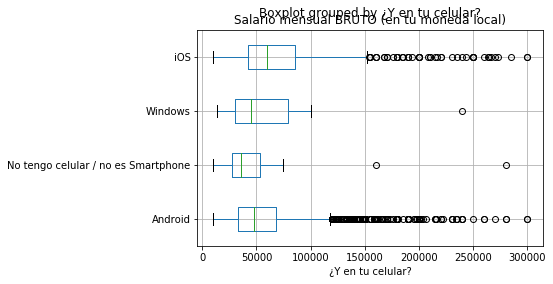

In [76]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', '¿Y en tu celular?', vert=False);

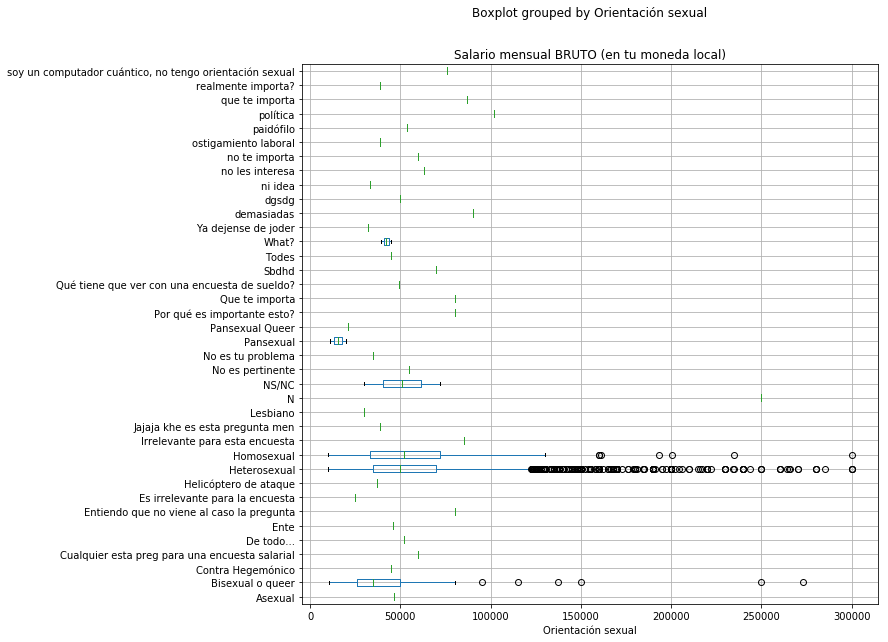

In [77]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', 'Orientación sexual', vert=False, figsize=(10, 10));

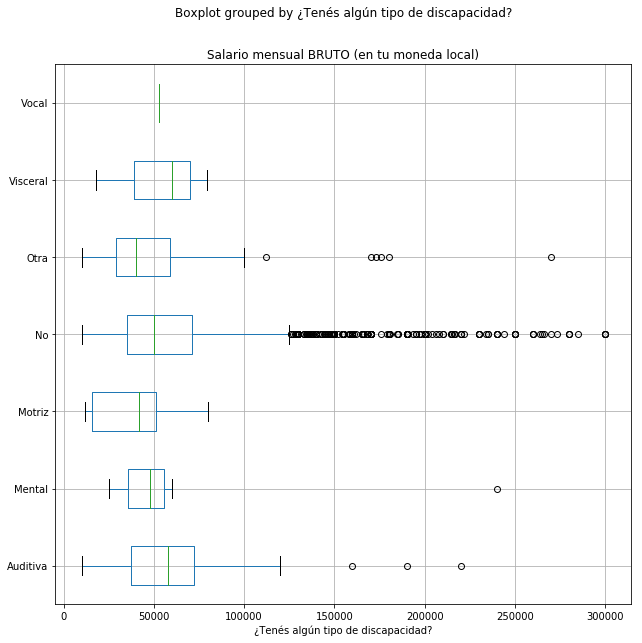

In [78]:
df_copy = df
df_copy['¿Tenés algún tipo de discapacidad?'] = df_copy['¿Tenés algún tipo de discapacidad?'].fillna('No')
df_copy.boxplot('Salario mensual BRUTO (en tu moneda local)', '¿Tenés algún tipo de discapacidad?', vert=False, figsize=(10, 10));

Ahora veamos de hacer un modelo de predicción lineal. Primero veamos cómo funciona predecir con pocas columnas el sueldo contra el logaritmo del sueldo. Como esta tiende a estar desbalanceado hacia valores extremos podemos aplicarle un logaritmo para que quede más parecida a una normal.

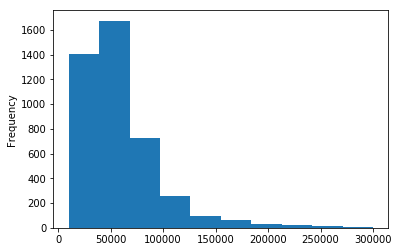

In [79]:
df[(df['Salario mensual BRUTO (en tu moneda local)'] >= 10000) & (df['Salario mensual BRUTO (en tu moneda local)'] <= 300000)]['Salario mensual BRUTO (en tu moneda local)'].plot.hist();


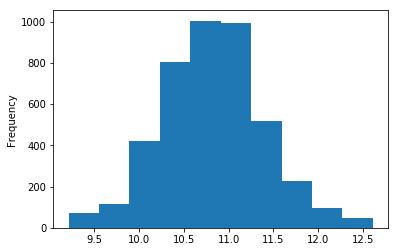

In [80]:
import numpy as np
np.log(df[(df['Salario mensual BRUTO (en tu moneda local)'] >= 10000) & (df['Salario mensual BRUTO (en tu moneda local)'] <= 300000)]['Salario mensual BRUTO (en tu moneda local)']).plot.hist();

Probemos con unas pocas columnas cómo se desempeña un modelo sencillo contra ambas.

Para eso tenemos que pasar todas las columnas a valores numéricos. Vamos a aplicar _one hot encoder_ para que el género sea 0 si es hombre, 1 si es mujer, 2 para los demás.

In [81]:
df1 = df[['Me identifico', 'Tengo', 'Años de experiencia', 'Salario mensual BRUTO (en tu moneda local)']]
df1.head()

,Me identifico,Tengo,Años de experiencia,Salario mensual BRUTO (en tu moneda local)
0,Hombre,22,2.0,35000.0
1,Hombre,23,2.0,25000.0
2,Mujer,35,8.0,50000.0
3,Hombre,41,20.0,70000.0
4,Hombre,35,5.0,35000.0


In [82]:
df1['Me identifico'] = df['Me identifico'].apply(lambda x: {
    'Hombre': 0,
    'Mujer': 1,
    'Otros': 2,
}[x])
df1.head()

/home/sebastianwaisbrot/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Me identifico,Tengo,Años de experiencia,Salario mensual BRUTO (en tu moneda local)
0,0,22,2.0,35000.0
1,0,23,2.0,25000.0
2,1,35,8.0,50000.0
3,0,41,20.0,70000.0
4,0,35,5.0,35000.0


In [83]:
from sklearn.linear_model import LinearRegression

X, y = df1[['Me identifico', 'Tengo', 'Años de experiencia']], df['Salario mensual BRUTO (en tu moneda local)']
reg = LinearRegression().fit(X, y)
reg.score(X, y) # r2

0.14023841085242794

In [84]:
from sklearn.linear_model import LinearRegression

X, y = df1[['Me identifico', 'Tengo', 'Años de experiencia']], np.log(df['Salario mensual BRUTO (en tu moneda local)'])
reg = LinearRegression().fit(X, y)
reg.score(X, y) # r2

0.1896083397218351

El score (r^2) es un número no mayor a 1 que representa qué parte del sueldo se puede explicar con las variables dadas. Vemos que es mayor cuando intentamos ver el logaritmo del salario en vez de su valor en pesos.

Veamos de usar para representar el género números correlativos usar el promedio del valor del sueldo.

In [85]:
df2 = df[['Me identifico', 'Tengo', 'Años de experiencia', 'Salario mensual BRUTO (en tu moneda local)']]
df2['logsalary'] = np.log(df2['Salario mensual BRUTO (en tu moneda local)'])
df2 = df2.drop('Salario mensual BRUTO (en tu moneda local)', axis=1)
gender_map = df2[['Me identifico', 'logsalary']].groupby('Me identifico').mean().to_dict()['logsalary']
df2['Me identifico'] = df2['Me identifico'].apply(lambda x: gender_map[x])
df2

/home/sebastianwaisbrot/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Me identifico,Tengo,Años de experiencia,logsalary
0,10.840954,22,2.0,10.463103
1,10.840954,23,2.0,10.126631
2,10.670173,35,8.0,10.819778
3,10.840954,41,20.0,11.156251
4,10.840954,35,5.0,10.463103
5,10.840954,38,16.0,10.757903
7,10.840954,32,10.0,10.736397
8,10.840954,28,7.0,12.429216
9,10.840954,29,0.0,9.740969
11,10.840954,27,8.0,11.982929


In [86]:
X, y = df2[['Me identifico', 'Tengo', 'Años de experiencia']], df2['logsalary']
reg = LinearRegression().fit(X, y)
reg.score(X, y) # r2

0.1900862757583052

El score mejora pero poco. Veamos de aplicarlo a las otras columnas también.

In [87]:
df3 = df[['Me identifico', 'Tengo', 'Años de experiencia', 'Salario mensual BRUTO (en tu moneda local)']]
df3['logsalary'] = np.log(df3['Salario mensual BRUTO (en tu moneda local)'])
df3 = df3.drop('Salario mensual BRUTO (en tu moneda local)', axis=1)
gender_map = df3[['Me identifico', 'logsalary']].groupby('Me identifico').mean().to_dict()['logsalary']
age_map = df3[['Tengo', 'logsalary']].groupby('Tengo').mean().to_dict()['logsalary']
df3['Me identifico'] = df3['Me identifico'].apply(lambda x: gender_map[x])
df3['Tengo'] = df3['Tengo'].apply(lambda x: age_map[x])
df3

/home/sebastianwaisbrot/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Me identifico,Tengo,Años de experiencia,logsalary
0,10.840954,10.250469,2.0,10.463103
1,10.840954,10.310936,2.0,10.126631
2,10.670173,11.028619,8.0,10.819778
3,10.840954,11.100770,20.0,11.156251
4,10.840954,11.028619,5.0,10.463103
5,10.840954,10.989701,16.0,10.757903
7,10.840954,10.897024,10.0,10.736397
8,10.840954,10.744458,7.0,12.429216
9,10.840954,10.770821,0.0,9.740969
11,10.840954,10.685548,8.0,11.982929


In [88]:
X, y = df3[['Me identifico', 'Tengo', 'Años de experiencia']], df3['logsalary']
reg = LinearRegression().fit(X, y)
reg.score(X, y) # r2

0.2364607301857835

In [89]:
import numpy as np
df4 = df[['Me identifico', 'Tengo', 'Años de experiencia', 'Salario mensual BRUTO (en tu moneda local)']]
df4['logsalary'] = np.log(df4['Salario mensual BRUTO (en tu moneda local)'])
df4 = df4.drop('Salario mensual BRUTO (en tu moneda local)', axis=1)
gender_map = df4[['Me identifico', 'logsalary']].groupby('Me identifico').mean().to_dict()['logsalary']
age_map = df4[['Tengo', 'logsalary']].groupby('Tengo').mean().to_dict()['logsalary']
exp_map = df4[['Años de experiencia', 'logsalary']].groupby('Años de experiencia').mean().to_dict()['logsalary']
df4['Me identifico'] = df4['Me identifico'].apply(lambda x: gender_map[x])
df4['Tengo'] = df4['Tengo'].apply(lambda x: age_map[x])
df4['Años de experiencia'] = df4['Años de experiencia'].apply(lambda x: exp_map[x])
df4

/home/sebastianwaisbrot/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Me identifico,Tengo,Años de experiencia,logsalary
0,10.840954,10.250469,10.431556,10.463103
1,10.840954,10.310936,10.431556,10.126631
2,10.670173,11.028619,10.913306,10.819778
3,10.840954,11.100770,11.113930,11.156251
4,10.840954,11.028619,10.709494,10.463103
5,10.840954,10.989701,11.151518,10.757903
7,10.840954,10.897024,10.949158,10.736397
8,10.840954,10.744458,10.853070,12.429216
9,10.840954,10.770821,10.106575,9.740969
11,10.840954,10.685548,10.913306,11.982929


In [90]:
X, y = df4[['Me identifico', 'Tengo', 'Años de experiencia']], df4['logsalary']
reg = LinearRegression().fit(X, y)
reg.score(X, y) # r2

0.28882472097730805

La mejora ya empieza a ser más significativa.

Sin embargo estamos evaluando al modelo con los datos de entrenamiento. En vez de eso vamos a aplicar _cross validation_ que separa del conjunto de datos un grupo que no se va a usar para entrenar y se usar sólo para testear. Una vez calculado el score, se devuelve este grupo y se saca otro.

In [91]:
df4.shape

(4293, 4)

In [92]:
df4.shape[0] // 5

858

In [93]:
from sklearn.model_selection import cross_val_score
lr = LinearRegression()
cross_val_score(lr, X, y, cv=5).mean()

0.26203974129482355

Al calcular los promedios de las categorías usé información que en _cross validation_ se usó para testear. Esto se llama _leak_ y es un error. Lo que debiera usar es el promedio de la categoría sólo con los datos de test.

In [101]:
df5 = df[['Me identifico', 'Tengo', 'Años de experiencia', 'Salario mensual BRUTO (en tu moneda local)']]
df5['logsalary'] = np.log(df5['Salario mensual BRUTO (en tu moneda local)'])
df5 = df5.drop('Salario mensual BRUTO (en tu moneda local)', axis=1)
df5

/home/sebastianwaisbrot/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Me identifico,Tengo,Años de experiencia,logsalary
0,Hombre,22,2.0,10.463103
1,Hombre,23,2.0,10.126631
2,Mujer,35,8.0,10.819778
3,Hombre,41,20.0,11.156251
4,Hombre,35,5.0,10.463103
5,Hombre,38,16.0,10.757903
7,Hombre,32,10.0,10.736397
8,Hombre,28,7.0,12.429216
9,Hombre,29,0.0,9.740969
11,Hombre,27,8.0,11.982929


In [102]:
import category_encoders as ce
encoder = ce.TargetEncoder(cols=['Tengo'])
encoder.fit_transform(df5[['Tengo']], df5['logsalary'])

,Tengo
0,10.250469
1,10.310936
2,11.028619
3,11.100770
4,11.028619
5,10.989701
7,10.897024
8,10.744458
9,10.770821
11,10.685548


In [104]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.TargetEncoder(cols=['Me identifico', 'Tengo', 'Años de experiencia']),
    LinearRegression(),
)

cross_val_score(pipeline, X, y, cv=5).mean()

0.24299575056646816

Probemos ahora incluir más columnas y veamos cómo cambiar el r2.

In [105]:
df.columns

Index(['Me identifico', 'Tengo', 'Dónde estás trabajando',
       'Años de experiencia', 'Años en la empresa actual',
       'Años en el puesto actual', '¿Gente a cargo?',
       'Nivel de estudios alcanzado', 'Estado', 'Carrera', 'Universidad',
       'Realizaste cursos de especialización',
       '¿Contribuís a proyectos open source?', '¿Programás como hobbie?',
       'Trabajo de', 'Plataformas', 'Lenguajes de programación',
       'Frameworks, herramientas y librerías', 'Bases de datos',
       'QA / Testing', 'IDEs', '¿Qué SO usás en tu laptop/PC para trabajar?',
       '¿Y en tu celular?', '¿Tenés guardias?', 'Cuánto cobrás por guardia',
       '¿Porcentaje, bruto o neto?', 'Tipo de contrato',
       'Salario mensual BRUTO (en tu moneda local)',
       'Salario mensual NETO (en tu moneda local)',
       '¿Qué tan conforme estás con tu sueldo?',
       'Cómo creés que está tu sueldo con respecto al último semestre',
       'Recibís algún tipo de bono', 'A qué está atado el bono',


In [118]:
from sklearn.pipeline import make_pipeline

cols = [
    'Me identifico',
    'Tengo',
    'Dónde estás trabajando',
    '¿Gente a cargo?',
    'Carrera',
    'Universidad',
    'Realizaste cursos de especialización',
    '¿Contribuís a proyectos open source?',
    '¿Programás como hobbie?',
    'Trabajo de',
    '¿Qué SO usás en tu laptop/PC para trabajar?',
    '¿Y en tu celular?',
    'Tipo de contrato',
    '¿Sufriste o presenciaste situaciones de violencia laboral?',
    'Orientación sexual',
    '¿Tenés algún tipo de discapacidad?',
    '¿A qué eventos de tecnología asististe en el último año?',
    'Cantidad de empleados',
    'Actividad principal',
    'years_exp', 'years_company', 'studied',
   'is_windows', 'is_lambda', 'is_vmware', 'is_containers', 'is_firebase',
   'is_unix', 'is_cloud', 'is_other', 'is_backend',
   'is_frontend', 'is_mobile', 'is_bigdata', 'is_.net', 'is_ml',
   'is_mobile_fw', 'is_frontend_fw', 'is_cms', 'is_backend_fw', 'is_sql',
   'is_nosql', 'is_selenium', 'is_NetBeans', 'is_PyCharm', 'is_Vi',
   'is_Atom', 'is_Android Studio', 'is_Eclipse', 'is_IntelliJ', 'is_Vim',
   'is_Notepad++', 'is_Sublime Text', 'is_Visual Studio']
pipeline = make_pipeline(
    ce.TargetEncoder(cols=cols),
    LinearRegression(),
)

cross_val_score(pipeline, df[cols], df4['logsalary'], cv=5).mean()

0.5572658456725386

Ahora podemos explicar mucho más del sueldo. También podemos ver cuál de las respuestas es más significativa sobre el salario.

PERO NO. Para poder ver eso en realidad debería normalizar los valores.

// TODO: restarle el promedio y dividir por el desvío

In [119]:
pipeline.fit(df[cols], df4['logsalary'])
dict(zip(cols, pipeline.steps[1][1].coef_.tolist()))

{'Actividad principal': 0.40462807525832545,
 'Cantidad de empleados': 0.602438930740647,
 'Carrera': 0.3561702152478825,
 'Dónde estás trabajando': 0.5479350989089172,
 'Me identifico': 0.33872241645979234,
 'Orientación sexual': 0.3087524835293731,
 'Realizaste cursos de especialización': 0.3481116169240017,
 'Tengo': 0.1964326314277628,
 'Tipo de contrato': 0.6295090982864591,
 'Trabajo de': 0.3719296090585348,
 'Universidad': 0.31318275335733214,
 'is_.net': 0.12968175295584422,
 'is_Android Studio': -0.3637507545073527,
 'is_Atom': -0.07338497060487947,
 'is_Eclipse': 0.42862081593313517,
 'is_IntelliJ': 0.22681844136447316,
 'is_NetBeans': 0.29365203282747304,
 'is_Notepad++': 0.3103581413977585,
 'is_PyCharm': 0.2447383189229002,
 'is_Sublime Text': -1.1106932296565593,
 'is_Vi': 0.2071047049753827,
 'is_Vim': 0.1352085204101207,
 'is_Visual Studio': 0.0020208735270146327,
 'is_backend': 0.4772186378204001,
 'is_backend_fw': 0.03921628624226366,
 'is_bigdata': -0.099207304726380

También podemos usar el modelo para buscar respuestas que difieran mucho de lo esperado y con eso filtrarlos si los consideramos que los datos son falsos. Veamos las tres respuestas que más se separan de lo que predice el modelo.

In [138]:
df6 = df
df6['logsalary'] = df4['logsalary']
df6['predicted'] = pd.Series(pipeline.predict(df[cols]))
df6['diff'] = (df6['predicted'] - df6['logsalary']).abs()
df6.sort_values('diff', ascending=False).iloc[0].to_dict()

{'A qué está atado el bono': 'No recibo bono',
 'Actividad principal': 'Otras industrias',
 'Años de experiencia': 20.0,
 'Años en el puesto actual': 20.0,
 'Años en la empresa actual': 3.0,
 'Bases de datos': nan,
 'Beneficios extra': 'Ninguna de las anteriores',
 'Cantidad de empleados': '11-50',
 'Carrera': 'Ingeniería',
 'Cuánto cobrás por guardia': 0.0,
 'Cómo creés que está tu sueldo con respecto al último semestre': 1,
 'Dónde estás trabajando': 'Ciudad Autónoma de Buenos Aires',
 'Estado': 'Incompleto',
 'Frameworks, herramientas y librerías': nan,
 'IDEs': nan,
 'Lenguajes de programación': nan,
 'Me identifico': 'Hombre',
 'Nivel de estudios alcanzado': 'Universitario',
 'Orientación sexual': 'Heterosexual',
 'Plataformas': 'Windows Server',
 'QA / Testing': nan,
 'Realizaste cursos de especialización': 'Sí, de forma particular',
 'Recibís algún tipo de bono': 'No',
 'Salario mensual BRUTO (en tu moneda local)': 10400.0,
 'Salario mensual NETO (en tu moneda local)': 10400.0,


In [139]:
df6.sort_values('diff', ascending=False).iloc[1].to_dict()

{'A qué está atado el bono': 'Bono de Fin de Año',
 'Actividad principal': 'Producto basado en Software',
 'Años de experiencia': 4.0,
 'Años en el puesto actual': 4.0,
 'Años en la empresa actual': 2.0,
 'Bases de datos': 'Amazon DynamoDB, MongoDB',
 'Beneficios extra': 'Capacitaciones y/o cursos, Horarios flexibles, Vacaciones flexibles (adicionales a las reglamentarias), Viajes al exterior, WFH (Trabajar desde casa)',
 'Cantidad de empleados': '11-50',
 'Carrera': 'Tecnicatura Electrónica',
 'Cuánto cobrás por guardia': 0.0,
 'Cómo creés que está tu sueldo con respecto al último semestre': 3,
 'Dónde estás trabajando': 'Provincia de Buenos Aires',
 'Estado': 'Completado',
 'Frameworks, herramientas y librerías': '.NET Core, Node.js, React.js',
 'IDEs': 'Android Studio, Vi, Vim, Visual Studio, Xcode, Visual Studio Code',
 'Lenguajes de programación': '.NET, C++, C#, CSS, HTML, Java, Javascript, Objective-C, Swift',
 'Me identifico': 'Hombre',
 'Nivel de estudios alcanzado': 'Terciari

In [140]:
df6.sort_values('diff', ascending=False).iloc[2].to_dict()

{'A qué está atado el bono': 'No recibo bono',
 'Actividad principal': 'Producto basado en Software',
 'Años de experiencia': 4.0,
 'Años en el puesto actual': 1.0,
 'Años en la empresa actual': 1.0,
 'Bases de datos': 'Google Cloud Storage, MongoDB, MySQL',
 'Beneficios extra': 'Capacitaciones y/o cursos, Horarios flexibles, Vacaciones flexibles (adicionales a las reglamentarias), Viajes al exterior, WFH (Trabajar desde casa)',
 'Cantidad de empleados': '1-10',
 'Carrera': 'Ingeniería en Sistemas de Computación',
 'Cuánto cobrás por guardia': 0.0,
 'Cómo creés que está tu sueldo con respecto al último semestre': 3,
 'Dónde estás trabajando': 'Provincia de Buenos Aires',
 'Estado': 'Completado',
 'Frameworks, herramientas y librerías': '.NET Core, Node.js, React.js',
 'IDEs': 'IntelliJ, Komodo, Visual Studio',
 'Lenguajes de programación': '.NET, C#, Go, HTML, Javascript, SQL',
 'Me identifico': 'Hombre',
 'Nivel de estudios alcanzado': 'Universitario',
 'Orientación sexual': 'Heterose

Los valores son llamativos pero no lo suficiente como para considerarlos falsos.